In [150]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import os
import wandb

# Dataset 상속
import torch
import torch.nn.functional as F
from torch.utils.data import Dataset
from torch.utils.data import DataLoader

import torch
from torch.autograd import Variable
from torch import Tensor
import torch.nn as nn

from sklearn.preprocessing import MinMaxScaler
from sklearn.model_selection import train_test_split

In [151]:
path = '/home/ines/github/lstm_short_game_golf/trainset_xyz_90'
file = 'set0.txt'
file = os.path.join(path, file)
df = pd.read_csv(file, sep=',', names = ['x','y','z','initial_velocity','launch_angle','spin_axis','xz_theta', 'spin_rate'])

cols = ['x','y','z']
df_extract = pd.DataFrame(df[cols])[0:10].transpose() # x,y,z 좌표 분리
df_extract.head()

,0,1,2,3,4,5,6,7,8,9
x,0.0,1.848574,3.678493,5.489051,7.280598,9.053479,10.808026,12.544567,14.263419,15.964893
y,0.0,0.742280,1.477614,2.212535,2.946855,3.680385,4.412939,5.144337,5.874403,6.602966
z,0.0,0.142366,0.284475,0.426175,0.567472,0.708371,0.848875,0.988991,1.128723,1.268075


In [152]:
for i in range(1, 5001):
    file = 'set{}.txt'.format(i)
    file = os.path.join(path, file)
    
    df = pd.read_csv(file, sep= ',', names = ['x', 'y', 'z','initial_velocity','launch_angle','spin_axis','xz_theta', 'spin_rate'])
    
    df_arr = pd.DataFrame(df[cols])[0:10].transpose() # x,y,z 행방향으로 병합
    df_extract = np.concatenate((df_extract, df_arr), axis=0)

print(df_extract.shape)
print('fin')

(15003, 10)
fin


In [153]:
# Normalization part : x(t+1)-x(t)

print(df_extract[0][0:10])
print(df_extract[1][0:10])
print(df_extract[2][0:10])

for i in range(len(df_extract)-1):
    for j in range(9,0,-1):
        df_extract[i][j] = df_extract[i][j] - df_extract[i][j-1]
        #print(df_extract[i][j])

print('---------After Normalization--------')
print(df_extract[0][0:10])
print(df_extract[1][0:10])
print(df_extract[2][0:10])

[ 0.          1.84857444  3.67849293  5.48905063  7.28059828  9.05347876
 10.80802638 12.54456714 14.26341911 15.96489269]
[0.         0.74228032 1.47761376 2.21253493 2.94685543 3.68038527
 4.41293928 5.1443371  5.87440303 6.602966  ]
[0.         0.14236608 0.28447467 0.42617509 0.56747212 0.70837064
 0.84887545 0.9889913  1.12872283 1.26807461]
---------After Normalization--------
[0.         1.84857444 1.8299185  1.8105577  1.79154765 1.77288049
 1.75454761 1.73654076 1.71885197 1.70147358]
[0.         0.74228032 0.73533344 0.73492117 0.7343205  0.73352984
 0.73255402 0.73139782 0.73006593 0.72856297]
[0.         0.14236608 0.14210859 0.14170043 0.14129703 0.14089852
 0.14050482 0.14011585 0.13973153 0.13935178]


In [154]:
file = 'set0.txt'
file = os.path.join(path, file)
df = pd.read_csv(file, sep=',', names = ['x','y','z','initial_velocity','launch_angle','spin_axis','xz_theta', 'spin_rate'])
label_df = df['spin_axis'][0].reshape(-1,1)

for i in range(1, 5001):
    file = 'set{}.txt'.format(i)
    file = os.path.join(path, file)
    
    df = pd.read_csv(file, sep= ',', names = ['x', 'y', 'z','initial_velocity','launch_angle','spin_axis','xz_theta', 'spin_rate'])
    
    label_arr = df['spin_axis'][0].reshape(-1,1) # label 열 방향으로 합치기
    label_df = np.concatenate((label_df, label_arr),axis=0)

print(label_df.shape)
print('fin')

(5001, 1)
fin


In [155]:
# Normalization part : label 
print(label_df)

scaler = MinMaxScaler()
scaler.fit(label_df[:])
scaled_df_extract = scaler.transform(label_df[:])

print('---------After Normalization--------')
scaled_df_extract

[[-1.44577835]
 [-4.04783856]
 [ 4.31992428]
 ...
 [ 1.00525162]
 [-1.2235629 ]
 [-1.40274044]]
---------After Normalization--------


array([[0.39652575],
       [0.21054841],
       [0.80861846],
       ...,
       [0.57170849],
       [0.41240818],
       [0.3996018 ]])

In [156]:
# X = x,y,z coordinate Y = parameter
x_size = 1503
y_size = 501

train_x_dataset,train_label = df_extract[:-x_size], scaled_df_extract[:-y_size]
test_x_dataset,test_label = df_extract[-x_size:], scaled_df_extract[-y_size:]

print('Training set:',train_x_dataset.shape,'Training label set:',train_label.shape)
print('Testing set:',test_x_dataset.shape,'Testing label set:',test_label.shape)

Training set: (13500, 10) Training label set: (4500, 1)
Testing set: (1503, 10) Testing label set: (501, 1)


In [157]:
# sample, sequence length, features
train_feature_tensors = Variable(torch.Tensor(train_x_dataset[:]))
train_label_tensors = Variable(torch.Tensor(train_label[:])).unsqueeze(dim=1)

test_feature_tensors = Variable(torch.Tensor(test_x_dataset[:]))
test_label_tensors = Variable(torch.Tensor(test_label[:])).unsqueeze(dim=1)

train_feature_tensors_f = torch.reshape(train_feature_tensors, 
                                  (train_feature_tensors.shape[0]//3,train_feature_tensors.shape[1],3))

test_feature_tensors_f = torch.reshape(test_feature_tensors,
                                (test_feature_tensors.shape[0]//3,test_feature_tensors.shape[1],3))

print('Training Shape :', train_feature_tensors_f.shape, train_label_tensors.shape)
print('Testing Shape :', test_feature_tensors_f.shape, test_label_tensors.shape)

Training Shape : torch.Size([4500, 10, 3]) torch.Size([4500, 1, 1])
Testing Shape : torch.Size([501, 10, 3]) torch.Size([501, 1, 1])


In [158]:
class CustomDataset(Dataset): 
    def __init__(self, x_data, y_data):
        self.x_data = x_data
        self.y_data = y_data
    
    # 총 데이터의 개수를 리턴
    def __len__(self): 
        return len(self.x_data)
    
    # 인덱스를 입력받아 그에 맵핑되는 입출력 데이터를 파이토치의 Tensor 형태로 리턴
    def __getitem__(self, idx): 
        x = torch.FloatTensor(self.x_data[idx,:])
        y = torch.FloatTensor(self.y_data[idx])
        return x, y

In [170]:
train_feature,train_label = train_feature_tensors_f,train_label_tensors

x_train, x_valid, y_train, y_valid = train_test_split(train_feature, train_label,test_size=0.2)

train_dataset = CustomDataset(x_train, y_train)
test_dataset = CustomDataset(test_feature_tensors_f, test_label_tensors)
valid_dataset = CustomDataset(x_valid, y_valid)

train_dataloader = DataLoader(train_dataset, batch_size=256, shuffle=True)
test_dataloader = DataLoader(test_dataset, batch_size=1, shuffle=True)
valid_dataloader = DataLoader(valid_dataset, batch_size=16, shuffle=True)

print('Training Shape:',x_train.shape, y_train.shape)
print('Validation Shape:',x_valid.shape, y_valid.shape)

Training Shape: torch.Size([3600, 10, 3]) torch.Size([3600, 1, 1])
Validation Shape: torch.Size([900, 10, 3]) torch.Size([900, 1, 1])


In [160]:
class LSTM_model(nn.Module):
    def __init__(self, num_classes, input_size, hidden_size, num_layers, seq_length):
        super(LSTM_model, self).__init__()
        self.num_classes = num_classes # 클래스
        self.num_layers = num_layers # LSTM 계층 개수
        self.input_size = input_size  # 입력 크기(컬럼 개수)
        self.hidden_size = hidden_size # 은닉층의 뉴런 개수
        self.seq_length = seq_length # 시퀀스 길이

        self.lstm = nn.LSTM(input_size=input_size, hidden_size=hidden_size,
                          num_layers=num_layers, batch_first=True) # lstm 
        self.fc_1 =  nn.Linear(hidden_size, 128) # 완전연결층
        self.fc = nn.Linear(128, num_classes) # 출력층
        #self.fc_2 =  nn.Linear(input_size*seq_length, 128)

        self.relu = nn.ReLU()
    
    def forward(self,x):
        h_0 = Variable(torch.zeros(self.num_layers, x.size(0), self.hidden_size)).cuda() # 은닉상태 초기화
        c_0 = Variable(torch.zeros(self.num_layers, x.size(0), self.hidden_size)).cuda() # 셀 상태 초기화
        
        output, (hn, cn) = self.lstm(x, (h_0, c_0)) # lstm 계층에 은닉 상태와 셀 상태 적용
        hn = hn.view(-1, self.hidden_size) # (1, hidden size)
        out = self.relu(hn)
        out = self.fc_1(out) 
        out = self.relu(out) 
        out = self.fc(out)
        #out = torch.sigmoid(out)
        return out

In [161]:
wandb.config = {
  "learning_rate": 0.00001,
  "epochs": 5000,
  "batch_size": 256
}
num_classes = 1
input_size=3 # features
hidden_size=128
num_layers=1
nb_epochs=5000

model = LSTM_model(num_classes, input_size, hidden_size, num_layers, train_feature_tensors_f.shape[1]).cuda()

criterion = torch.nn.MSELoss()
optimizer = torch.optim.Adam(model.parameters(), lr=0.001)

In [162]:
train_loss = []
valid_list = []
train_dataset = []
train_prediction = []

wandb.init(project='test-project', entity='ines-kwak', reinit=True)

loss = nn.MSELoss()

for epoch in range(nb_epochs + 1):
    
    model.train()
    
    for batch_idx, samples in enumerate(train_dataloader):
        x_train, y_train = samples
        x_train=x_train.cuda()
        y_train=y_train.cuda()[:,0]
        
        
        
        optimizer.zero_grad()
        
        # H(x) 계산
        prediction = model(x_train)
        
        
        # cost 계산
        cost = loss(prediction, y_train)

        # cost로 H(x) 계산
        cost.backward()
        optimizer.step()
        

        #train_prediction.append(prediction.cpu())
        
        if batch_idx % 10 == 0:
            print('Epoch {:4d}/{} Batch {}/{} Cost: {:.6f}'.format(
                epoch, nb_epochs, batch_idx+1, len(train_dataloader),
                cost.item()
                ))
        wandb.log({'train/loss': cost.item()})
        #wandb.watch(model)
        
        train_dataset.append(torch.flatten(y_train).cpu().numpy())
        train_prediction.append(torch.flatten(prediction).cpu().detach().numpy())
    #break
    
    model.eval()
    valid_cost = 0
    for batch_idx, samples in enumerate(valid_dataloader):
        x_train, y_train = samples
        x_train, y_train = x_train.cuda(),y_train.cuda()[:,0]
        valid_prediction = model(x_train)

        valid_cost += loss(valid_prediction, y_train)
        
    
        valid_list.append(valid_cost.item())
    wandb.log({'validation/loss': valid_cost.item()})
        
    print('Cost: {:.6f}'.format(valid_cost.item()))

train/loss,▇█▃▃▂▂▁▄▁▁▁▁▁▁▁▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▂▁▁▁▁▁▁▁▁
validation/loss,██▅▂▂▁▁▂▁▂▁▁▁▁▁▁▃▁▁▁▁▁▁▁▁▁▂▁▁▁▁▁▁▁▁▁▁▂▂▁
train/loss,0.00068
validation/loss,0.22874


Epoch    0/5000 Batch 1/15 Cost: 0.450303
Epoch    0/5000 Batch 11/15 Cost: 0.208645
Cost: 5.361426
Epoch    1/5000 Batch 1/15 Cost: 0.096854
Epoch    1/5000 Batch 11/15 Cost: 0.101922
Cost: 4.876475
Epoch    2/5000 Batch 1/15 Cost: 0.085407
Epoch    2/5000 Batch 11/15 Cost: 0.087961
Cost: 4.754276
Epoch    3/5000 Batch 1/15 Cost: 0.083747
Epoch    3/5000 Batch 11/15 Cost: 0.082105
Cost: 4.783413
Epoch    4/5000 Batch 1/15 Cost: 0.083285
Epoch    4/5000 Batch 11/15 Cost: 0.075222
Cost: 4.775959
Epoch    5/5000 Batch 1/15 Cost: 0.078377
Epoch    5/5000 Batch 11/15 Cost: 0.076353
Cost: 4.823560
Epoch    6/5000 Batch 1/15 Cost: 0.081966
Epoch    6/5000 Batch 11/15 Cost: 0.081615
Cost: 4.794071
Epoch    7/5000 Batch 1/15 Cost: 0.089102
Epoch    7/5000 Batch 11/15 Cost: 0.095689
Cost: 4.755549
Epoch    8/5000 Batch 1/15 Cost: 0.086897
Epoch    8/5000 Batch 11/15 Cost: 0.077148
Cost: 4.768019
Epoch    9/5000 Batch 1/15 Cost: 0.093771
Epoch    9/5000 Batch 11/15 Cost: 0.085801
Cost: 4.833140


Epoch   84/5000 Batch 11/15 Cost: 0.078821
Cost: 4.787242
Epoch   85/5000 Batch 1/15 Cost: 0.083606
Epoch   85/5000 Batch 11/15 Cost: 0.084702
Cost: 4.719306
Epoch   86/5000 Batch 1/15 Cost: 0.080119
Epoch   86/5000 Batch 11/15 Cost: 0.085094
Cost: 4.753932
Epoch   87/5000 Batch 1/15 Cost: 0.077877
Epoch   87/5000 Batch 11/15 Cost: 0.082143
Cost: 4.757958
Epoch   88/5000 Batch 1/15 Cost: 0.073710
Epoch   88/5000 Batch 11/15 Cost: 0.093816
Cost: 4.932134
Epoch   89/5000 Batch 1/15 Cost: 0.076431
Epoch   89/5000 Batch 11/15 Cost: 0.080380
Cost: 4.869279
Epoch   90/5000 Batch 1/15 Cost: 0.088496
Epoch   90/5000 Batch 11/15 Cost: 0.079299
Cost: 4.761441
Epoch   91/5000 Batch 1/15 Cost: 0.081585
Epoch   91/5000 Batch 11/15 Cost: 0.083079
Cost: 4.795927
Epoch   92/5000 Batch 1/15 Cost: 0.087008
Epoch   92/5000 Batch 11/15 Cost: 0.086281
Cost: 4.804066
Epoch   93/5000 Batch 1/15 Cost: 0.084613
Epoch   93/5000 Batch 11/15 Cost: 0.087191
Cost: 4.755536
Epoch   94/5000 Batch 1/15 Cost: 0.087577


Epoch  168/5000 Batch 1/15 Cost: 0.074459
Epoch  168/5000 Batch 11/15 Cost: 0.065716
Cost: 4.026695
Epoch  169/5000 Batch 1/15 Cost: 0.066925
Epoch  169/5000 Batch 11/15 Cost: 0.063135
Cost: 4.060223
Epoch  170/5000 Batch 1/15 Cost: 0.061150
Epoch  170/5000 Batch 11/15 Cost: 0.065820
Cost: 5.469252
Epoch  171/5000 Batch 1/15 Cost: 0.101708
Epoch  171/5000 Batch 11/15 Cost: 0.072217
Cost: 3.903325
Epoch  172/5000 Batch 1/15 Cost: 0.059138
Epoch  172/5000 Batch 11/15 Cost: 0.064022
Cost: 3.910527
Epoch  173/5000 Batch 1/15 Cost: 0.064792
Epoch  173/5000 Batch 11/15 Cost: 0.065542
Cost: 3.664398
Epoch  174/5000 Batch 1/15 Cost: 0.064746
Epoch  174/5000 Batch 11/15 Cost: 0.062074
Cost: 3.710418
Epoch  175/5000 Batch 1/15 Cost: 0.062404
Epoch  175/5000 Batch 11/15 Cost: 0.064921
Cost: 3.687077
Epoch  176/5000 Batch 1/15 Cost: 0.061533
Epoch  176/5000 Batch 11/15 Cost: 0.058431
Cost: 3.372076
Epoch  177/5000 Batch 1/15 Cost: 0.049693
Epoch  177/5000 Batch 11/15 Cost: 0.060844
Cost: 3.131484


Epoch  250/5000 Batch 11/15 Cost: 0.012847
Cost: 1.838140
Epoch  251/5000 Batch 1/15 Cost: 0.029600
Epoch  251/5000 Batch 11/15 Cost: 0.023403
Cost: 1.173777
Epoch  252/5000 Batch 1/15 Cost: 0.012679
Epoch  252/5000 Batch 11/15 Cost: 0.017077
Cost: 2.026095
Epoch  253/5000 Batch 1/15 Cost: 0.033870
Epoch  253/5000 Batch 11/15 Cost: 0.020965
Cost: 1.056907
Epoch  254/5000 Batch 1/15 Cost: 0.015030
Epoch  254/5000 Batch 11/15 Cost: 0.012942
Cost: 0.987843
Epoch  255/5000 Batch 1/15 Cost: 0.012166
Epoch  255/5000 Batch 11/15 Cost: 0.013845
Cost: 1.017054
Epoch  256/5000 Batch 1/15 Cost: 0.014436
Epoch  256/5000 Batch 11/15 Cost: 0.013180
Cost: 1.023461
Epoch  257/5000 Batch 1/15 Cost: 0.010365
Epoch  257/5000 Batch 11/15 Cost: 0.011184
Cost: 1.344985
Epoch  258/5000 Batch 1/15 Cost: 0.017330
Epoch  258/5000 Batch 11/15 Cost: 0.013557
Cost: 1.021932
Epoch  259/5000 Batch 1/15 Cost: 0.011512
Epoch  259/5000 Batch 11/15 Cost: 0.010195
Cost: 1.648789
Epoch  260/5000 Batch 1/15 Cost: 0.024050


Epoch  332/5000 Batch 11/15 Cost: 0.011687
Cost: 0.776747
Epoch  333/5000 Batch 1/15 Cost: 0.007827
Epoch  333/5000 Batch 11/15 Cost: 0.006425
Cost: 0.736325
Epoch  334/5000 Batch 1/15 Cost: 0.006596
Epoch  334/5000 Batch 11/15 Cost: 0.005935
Cost: 0.698547
Epoch  335/5000 Batch 1/15 Cost: 0.007208
Epoch  335/5000 Batch 11/15 Cost: 0.006825
Cost: 0.688000
Epoch  336/5000 Batch 1/15 Cost: 0.005210
Epoch  336/5000 Batch 11/15 Cost: 0.006653
Cost: 0.710778
Epoch  337/5000 Batch 1/15 Cost: 0.005359
Epoch  337/5000 Batch 11/15 Cost: 0.006548
Cost: 0.918722
Epoch  338/5000 Batch 1/15 Cost: 0.012104
Epoch  338/5000 Batch 11/15 Cost: 0.008083
Cost: 0.745223
Epoch  339/5000 Batch 1/15 Cost: 0.008322
Epoch  339/5000 Batch 11/15 Cost: 0.006968
Cost: 0.716038
Epoch  340/5000 Batch 1/15 Cost: 0.007737
Epoch  340/5000 Batch 11/15 Cost: 0.006685
Cost: 1.049223
Epoch  341/5000 Batch 1/15 Cost: 0.016935
Epoch  341/5000 Batch 11/15 Cost: 0.010137
Cost: 0.860237
Epoch  342/5000 Batch 1/15 Cost: 0.011503


Epoch  416/5000 Batch 11/15 Cost: 0.008780
Cost: 1.075894
Epoch  417/5000 Batch 1/15 Cost: 0.015428
Epoch  417/5000 Batch 11/15 Cost: 0.007058
Cost: 0.719566
Epoch  418/5000 Batch 1/15 Cost: 0.006776
Epoch  418/5000 Batch 11/15 Cost: 0.006245
Cost: 0.747328
Epoch  419/5000 Batch 1/15 Cost: 0.007513
Epoch  419/5000 Batch 11/15 Cost: 0.006995
Cost: 0.733456
Epoch  420/5000 Batch 1/15 Cost: 0.005333
Epoch  420/5000 Batch 11/15 Cost: 0.007167
Cost: 0.632583
Epoch  421/5000 Batch 1/15 Cost: 0.005178
Epoch  421/5000 Batch 11/15 Cost: 0.005862
Cost: 0.640114
Epoch  422/5000 Batch 1/15 Cost: 0.007716
Epoch  422/5000 Batch 11/15 Cost: 0.005449
Cost: 0.673470
Epoch  423/5000 Batch 1/15 Cost: 0.003325
Epoch  423/5000 Batch 11/15 Cost: 0.005337
Cost: 0.744475
Epoch  424/5000 Batch 1/15 Cost: 0.007189
Epoch  424/5000 Batch 11/15 Cost: 0.004207
Cost: 0.750587
Epoch  425/5000 Batch 1/15 Cost: 0.005559
Epoch  425/5000 Batch 11/15 Cost: 0.006860
Cost: 0.621062
Epoch  426/5000 Batch 1/15 Cost: 0.005471


Epoch  499/5000 Batch 1/15 Cost: 0.002647
Epoch  499/5000 Batch 11/15 Cost: 0.002757
Cost: 0.654926
Epoch  500/5000 Batch 1/15 Cost: 0.004131
Epoch  500/5000 Batch 11/15 Cost: 0.003497
Cost: 0.628893
Epoch  501/5000 Batch 1/15 Cost: 0.004111
Epoch  501/5000 Batch 11/15 Cost: 0.003198
Cost: 0.635113
Epoch  502/5000 Batch 1/15 Cost: 0.003577
Epoch  502/5000 Batch 11/15 Cost: 0.003666
Cost: 0.608881
Epoch  503/5000 Batch 1/15 Cost: 0.004563
Epoch  503/5000 Batch 11/15 Cost: 0.004500
Cost: 0.642641
Epoch  504/5000 Batch 1/15 Cost: 0.004897
Epoch  504/5000 Batch 11/15 Cost: 0.007477
Cost: 1.101066
Epoch  505/5000 Batch 1/15 Cost: 0.015358
Epoch  505/5000 Batch 11/15 Cost: 0.004316
Cost: 0.610554
Epoch  506/5000 Batch 1/15 Cost: 0.004734
Epoch  506/5000 Batch 11/15 Cost: 0.006413
Cost: 0.650268
Epoch  507/5000 Batch 1/15 Cost: 0.004782
Epoch  507/5000 Batch 11/15 Cost: 0.004193
Cost: 0.631699
Epoch  508/5000 Batch 1/15 Cost: 0.004377
Epoch  508/5000 Batch 11/15 Cost: 0.004658
Cost: 0.829437


Epoch  581/5000 Batch 11/15 Cost: 0.005694
Cost: 0.903823
Epoch  582/5000 Batch 1/15 Cost: 0.009197
Epoch  582/5000 Batch 11/15 Cost: 0.007153
Cost: 0.932642
Epoch  583/5000 Batch 1/15 Cost: 0.007701
Epoch  583/5000 Batch 11/15 Cost: 0.009877
Cost: 0.668931
Epoch  584/5000 Batch 1/15 Cost: 0.002739
Epoch  584/5000 Batch 11/15 Cost: 0.002309
Cost: 0.682779
Epoch  585/5000 Batch 1/15 Cost: 0.002869
Epoch  585/5000 Batch 11/15 Cost: 0.002874
Cost: 0.710651
Epoch  586/5000 Batch 1/15 Cost: 0.003332
Epoch  586/5000 Batch 11/15 Cost: 0.003050
Cost: 0.658427
Epoch  587/5000 Batch 1/15 Cost: 0.002563
Epoch  587/5000 Batch 11/15 Cost: 0.004180
Cost: 0.786168
Epoch  588/5000 Batch 1/15 Cost: 0.003232
Epoch  588/5000 Batch 11/15 Cost: 0.002660
Cost: 0.931815
Epoch  589/5000 Batch 1/15 Cost: 0.006872
Epoch  589/5000 Batch 11/15 Cost: 0.002911
Cost: 0.728164
Epoch  590/5000 Batch 1/15 Cost: 0.003273
Epoch  590/5000 Batch 11/15 Cost: 0.003652
Cost: 0.802137
Epoch  591/5000 Batch 1/15 Cost: 0.005201


Epoch  664/5000 Batch 11/15 Cost: 0.006337
Cost: 0.788764
Epoch  665/5000 Batch 1/15 Cost: 0.002390
Epoch  665/5000 Batch 11/15 Cost: 0.002723
Cost: 1.069063
Epoch  666/5000 Batch 1/15 Cost: 0.011408
Epoch  666/5000 Batch 11/15 Cost: 0.005929
Cost: 0.923370
Epoch  667/5000 Batch 1/15 Cost: 0.002666
Epoch  667/5000 Batch 11/15 Cost: 0.003245
Cost: 0.800179
Epoch  668/5000 Batch 1/15 Cost: 0.003340
Epoch  668/5000 Batch 11/15 Cost: 0.003380
Cost: 0.896871
Epoch  669/5000 Batch 1/15 Cost: 0.002036
Epoch  669/5000 Batch 11/15 Cost: 0.002635
Cost: 0.717432
Epoch  670/5000 Batch 1/15 Cost: 0.003421
Epoch  670/5000 Batch 11/15 Cost: 0.001813
Cost: 0.805719
Epoch  671/5000 Batch 1/15 Cost: 0.002212
Epoch  671/5000 Batch 11/15 Cost: 0.001775
Cost: 0.890926
Epoch  672/5000 Batch 1/15 Cost: 0.002894
Epoch  672/5000 Batch 11/15 Cost: 0.002562
Cost: 0.889690
Epoch  673/5000 Batch 1/15 Cost: 0.003230
Epoch  673/5000 Batch 11/15 Cost: 0.003738
Cost: 0.894316
Epoch  674/5000 Batch 1/15 Cost: 0.003349


Cost: 1.708775
Epoch  748/5000 Batch 1/15 Cost: 0.007480
Epoch  748/5000 Batch 11/15 Cost: 0.005048
Cost: 1.034153
Epoch  749/5000 Batch 1/15 Cost: 0.002010
Epoch  749/5000 Batch 11/15 Cost: 0.001884
Cost: 1.467566
Epoch  750/5000 Batch 1/15 Cost: 0.003806
Epoch  750/5000 Batch 11/15 Cost: 0.004298
Cost: 1.291072
Epoch  751/5000 Batch 1/15 Cost: 0.004092
Epoch  751/5000 Batch 11/15 Cost: 0.001985
Cost: 1.116969
Epoch  752/5000 Batch 1/15 Cost: 0.002102
Epoch  752/5000 Batch 11/15 Cost: 0.001609
Cost: 1.548058
Epoch  753/5000 Batch 1/15 Cost: 0.002418
Epoch  753/5000 Batch 11/15 Cost: 0.002983
Cost: 1.601557
Epoch  754/5000 Batch 1/15 Cost: 0.011820
Epoch  754/5000 Batch 11/15 Cost: 0.006139
Cost: 2.419444
Epoch  755/5000 Batch 1/15 Cost: 0.007320
Epoch  755/5000 Batch 11/15 Cost: 0.003515
Cost: 0.826367
Epoch  756/5000 Batch 1/15 Cost: 0.004519
Epoch  756/5000 Batch 11/15 Cost: 0.002316
Cost: 1.938910
Epoch  757/5000 Batch 1/15 Cost: 0.002163
Epoch  757/5000 Batch 11/15 Cost: 0.003610


Epoch  831/5000 Batch 11/15 Cost: 0.002183
Cost: 1.361375
Epoch  832/5000 Batch 1/15 Cost: 0.002785
Epoch  832/5000 Batch 11/15 Cost: 0.001692
Cost: 2.103304
Epoch  833/5000 Batch 1/15 Cost: 0.005712
Epoch  833/5000 Batch 11/15 Cost: 0.002504
Cost: 1.996213
Epoch  834/5000 Batch 1/15 Cost: 0.007614
Epoch  834/5000 Batch 11/15 Cost: 0.001752
Cost: 2.510664
Epoch  835/5000 Batch 1/15 Cost: 0.004962
Epoch  835/5000 Batch 11/15 Cost: 0.002119
Cost: 1.047624
Epoch  836/5000 Batch 1/15 Cost: 0.004236
Epoch  836/5000 Batch 11/15 Cost: 0.003264
Cost: 1.790162
Epoch  837/5000 Batch 1/15 Cost: 0.002045
Epoch  837/5000 Batch 11/15 Cost: 0.002090
Cost: 1.892873
Epoch  838/5000 Batch 1/15 Cost: 0.002478
Epoch  838/5000 Batch 11/15 Cost: 0.002277
Cost: 2.136946
Epoch  839/5000 Batch 1/15 Cost: 0.003817
Epoch  839/5000 Batch 11/15 Cost: 0.003807
Cost: 2.907395
Epoch  840/5000 Batch 1/15 Cost: 0.011138
Epoch  840/5000 Batch 11/15 Cost: 0.006736
Cost: 1.776709
Epoch  841/5000 Batch 1/15 Cost: 0.001677


Epoch  914/5000 Batch 11/15 Cost: 0.001877
Cost: 3.120218
Epoch  915/5000 Batch 1/15 Cost: 0.001801
Epoch  915/5000 Batch 11/15 Cost: 0.002251
Cost: 3.047955
Epoch  916/5000 Batch 1/15 Cost: 0.003978
Epoch  916/5000 Batch 11/15 Cost: 0.003259
Cost: 3.256706
Epoch  917/5000 Batch 1/15 Cost: 0.013614
Epoch  917/5000 Batch 11/15 Cost: 0.003779
Cost: 3.050692
Epoch  918/5000 Batch 1/15 Cost: 0.007325
Epoch  918/5000 Batch 11/15 Cost: 0.004143
Cost: 2.625865
Epoch  919/5000 Batch 1/15 Cost: 0.003802
Epoch  919/5000 Batch 11/15 Cost: 0.001911
Cost: 3.568964
Epoch  920/5000 Batch 1/15 Cost: 0.003434
Epoch  920/5000 Batch 11/15 Cost: 0.003221
Cost: 2.392669
Epoch  921/5000 Batch 1/15 Cost: 0.002389
Epoch  921/5000 Batch 11/15 Cost: 0.001949
Cost: 3.075101
Epoch  922/5000 Batch 1/15 Cost: 0.002083
Epoch  922/5000 Batch 11/15 Cost: 0.002070
Cost: 2.518323
Epoch  923/5000 Batch 1/15 Cost: 0.001669
Epoch  923/5000 Batch 11/15 Cost: 0.001408
Cost: 2.376853
Epoch  924/5000 Batch 1/15 Cost: 0.003429


Cost: 2.472897
Epoch  997/5000 Batch 1/15 Cost: 0.001874
Epoch  997/5000 Batch 11/15 Cost: 0.001739
Cost: 2.759283
Epoch  998/5000 Batch 1/15 Cost: 0.001610
Epoch  998/5000 Batch 11/15 Cost: 0.001318
Cost: 2.620179
Epoch  999/5000 Batch 1/15 Cost: 0.001604
Epoch  999/5000 Batch 11/15 Cost: 0.001747
Cost: 1.436018
Epoch 1000/5000 Batch 1/15 Cost: 0.001683
Epoch 1000/5000 Batch 11/15 Cost: 0.001518
Cost: 4.812224
Epoch 1001/5000 Batch 1/15 Cost: 0.002942
Epoch 1001/5000 Batch 11/15 Cost: 0.002095
Cost: 2.186403
Epoch 1002/5000 Batch 1/15 Cost: 0.001396
Epoch 1002/5000 Batch 11/15 Cost: 0.001801
Cost: 5.881843
Epoch 1003/5000 Batch 1/15 Cost: 0.002503
Epoch 1003/5000 Batch 11/15 Cost: 0.002650
Cost: 2.768984
Epoch 1004/5000 Batch 1/15 Cost: 0.001707
Epoch 1004/5000 Batch 11/15 Cost: 0.001543
Cost: 2.799593
Epoch 1005/5000 Batch 1/15 Cost: 0.002264
Epoch 1005/5000 Batch 11/15 Cost: 0.002214
Cost: 2.230239
Epoch 1006/5000 Batch 1/15 Cost: 0.001852
Epoch 1006/5000 Batch 11/15 Cost: 0.001432


Cost: 0.263678
Epoch 1079/5000 Batch 1/15 Cost: 0.002021
Epoch 1079/5000 Batch 11/15 Cost: 0.002368
Cost: 0.266991
Epoch 1080/5000 Batch 1/15 Cost: 0.002812
Epoch 1080/5000 Batch 11/15 Cost: 0.001228
Cost: 0.246685
Epoch 1081/5000 Batch 1/15 Cost: 0.002602
Epoch 1081/5000 Batch 11/15 Cost: 0.002353
Cost: 0.243672
Epoch 1082/5000 Batch 1/15 Cost: 0.001161
Epoch 1082/5000 Batch 11/15 Cost: 0.001407
Cost: 0.238486
Epoch 1083/5000 Batch 1/15 Cost: 0.001551
Epoch 1083/5000 Batch 11/15 Cost: 0.002258
Cost: 0.246233
Epoch 1084/5000 Batch 1/15 Cost: 0.001993
Epoch 1084/5000 Batch 11/15 Cost: 0.001226
Cost: 0.266732
Epoch 1085/5000 Batch 1/15 Cost: 0.002461
Epoch 1085/5000 Batch 11/15 Cost: 0.001818
Cost: 0.223499
Epoch 1086/5000 Batch 1/15 Cost: 0.002077
Epoch 1086/5000 Batch 11/15 Cost: 0.002464
Cost: 0.269340
Epoch 1087/5000 Batch 1/15 Cost: 0.002293
Epoch 1087/5000 Batch 11/15 Cost: 0.001231
Cost: 0.548838
Epoch 1088/5000 Batch 1/15 Cost: 0.007795
Epoch 1088/5000 Batch 11/15 Cost: 0.002108


Cost: 2.864856
Epoch 1162/5000 Batch 1/15 Cost: 0.001716
Epoch 1162/5000 Batch 11/15 Cost: 0.002826
Cost: 3.071387
Epoch 1163/5000 Batch 1/15 Cost: 0.002313
Epoch 1163/5000 Batch 11/15 Cost: 0.002946
Cost: 2.883336
Epoch 1164/5000 Batch 1/15 Cost: 0.001413
Epoch 1164/5000 Batch 11/15 Cost: 0.001591
Cost: 2.787175
Epoch 1165/5000 Batch 1/15 Cost: 0.001248
Epoch 1165/5000 Batch 11/15 Cost: 0.002616
Cost: 3.154301
Epoch 1166/5000 Batch 1/15 Cost: 0.001725
Epoch 1166/5000 Batch 11/15 Cost: 0.002887
Cost: 2.077176
Epoch 1167/5000 Batch 1/15 Cost: 0.001936
Epoch 1167/5000 Batch 11/15 Cost: 0.002014
Cost: 3.059870
Epoch 1168/5000 Batch 1/15 Cost: 0.002574
Epoch 1168/5000 Batch 11/15 Cost: 0.002049
Cost: 6.872811
Epoch 1169/5000 Batch 1/15 Cost: 0.004646
Epoch 1169/5000 Batch 11/15 Cost: 0.003431
Cost: 5.398728
Epoch 1170/5000 Batch 1/15 Cost: 0.007074
Epoch 1170/5000 Batch 11/15 Cost: 0.001916
Cost: 5.106368
Epoch 1171/5000 Batch 1/15 Cost: 0.004168
Epoch 1171/5000 Batch 11/15 Cost: 0.008528


Cost: 20.662308
Epoch 1244/5000 Batch 1/15 Cost: 0.002166
Epoch 1244/5000 Batch 11/15 Cost: 0.001530
Cost: 21.186699
Epoch 1245/5000 Batch 1/15 Cost: 0.001877
Epoch 1245/5000 Batch 11/15 Cost: 0.001460
Cost: 22.596201
Epoch 1246/5000 Batch 1/15 Cost: 0.000958
Epoch 1246/5000 Batch 11/15 Cost: 0.001325
Cost: 21.662283
Epoch 1247/5000 Batch 1/15 Cost: 0.002446
Epoch 1247/5000 Batch 11/15 Cost: 0.001721
Cost: 15.998990
Epoch 1248/5000 Batch 1/15 Cost: 0.001112
Epoch 1248/5000 Batch 11/15 Cost: 0.001415
Cost: 18.220827
Epoch 1249/5000 Batch 1/15 Cost: 0.002008
Epoch 1249/5000 Batch 11/15 Cost: 0.001481
Cost: 24.032566
Epoch 1250/5000 Batch 1/15 Cost: 0.001924
Epoch 1250/5000 Batch 11/15 Cost: 0.001336
Cost: 24.748611
Epoch 1251/5000 Batch 1/15 Cost: 0.003176
Epoch 1251/5000 Batch 11/15 Cost: 0.002046
Cost: 25.174187
Epoch 1252/5000 Batch 1/15 Cost: 0.001649
Epoch 1252/5000 Batch 11/15 Cost: 0.001766
Cost: 22.817423
Epoch 1253/5000 Batch 1/15 Cost: 0.002423
Epoch 1253/5000 Batch 11/15 Cost:

Cost: 23.422375
Epoch 1327/5000 Batch 1/15 Cost: 0.001192
Epoch 1327/5000 Batch 11/15 Cost: 0.001177
Cost: 24.960163
Epoch 1328/5000 Batch 1/15 Cost: 0.001608
Epoch 1328/5000 Batch 11/15 Cost: 0.001200
Cost: 22.349443
Epoch 1329/5000 Batch 1/15 Cost: 0.001876
Epoch 1329/5000 Batch 11/15 Cost: 0.002543
Cost: 18.011034
Epoch 1330/5000 Batch 1/15 Cost: 0.001916
Epoch 1330/5000 Batch 11/15 Cost: 0.003110
Cost: 29.964626
Epoch 1331/5000 Batch 1/15 Cost: 0.001448
Epoch 1331/5000 Batch 11/15 Cost: 0.001995
Cost: 32.203796
Epoch 1332/5000 Batch 1/15 Cost: 0.005947
Epoch 1332/5000 Batch 11/15 Cost: 0.004765
Cost: 31.413492
Epoch 1333/5000 Batch 1/15 Cost: 0.001533
Epoch 1333/5000 Batch 11/15 Cost: 0.001402
Cost: 33.737835
Epoch 1334/5000 Batch 1/15 Cost: 0.007057
Epoch 1334/5000 Batch 11/15 Cost: 0.003353
Cost: 31.753654
Epoch 1335/5000 Batch 1/15 Cost: 0.001399
Epoch 1335/5000 Batch 11/15 Cost: 0.001552
Cost: 32.433105
Epoch 1336/5000 Batch 1/15 Cost: 0.003465
Epoch 1336/5000 Batch 11/15 Cost:

Cost: 20.821003
Epoch 1410/5000 Batch 1/15 Cost: 0.002059
Epoch 1410/5000 Batch 11/15 Cost: 0.002385
Cost: 20.816584
Epoch 1411/5000 Batch 1/15 Cost: 0.001555
Epoch 1411/5000 Batch 11/15 Cost: 0.001622
Cost: 22.018677
Epoch 1412/5000 Batch 1/15 Cost: 0.004606
Epoch 1412/5000 Batch 11/15 Cost: 0.002720
Cost: 21.546913
Epoch 1413/5000 Batch 1/15 Cost: 0.001064
Epoch 1413/5000 Batch 11/15 Cost: 0.001494
Cost: 20.542608
Epoch 1414/5000 Batch 1/15 Cost: 0.002634
Epoch 1414/5000 Batch 11/15 Cost: 0.002840
Cost: 19.833109
Epoch 1415/5000 Batch 1/15 Cost: 0.002154
Epoch 1415/5000 Batch 11/15 Cost: 0.001398
Cost: 22.933470
Epoch 1416/5000 Batch 1/15 Cost: 0.000974
Epoch 1416/5000 Batch 11/15 Cost: 0.001195
Cost: 19.969324
Epoch 1417/5000 Batch 1/15 Cost: 0.006112
Epoch 1417/5000 Batch 11/15 Cost: 0.003685
Cost: 22.779284
Epoch 1418/5000 Batch 1/15 Cost: 0.001354
Epoch 1418/5000 Batch 11/15 Cost: 0.001863
Cost: 21.113712
Epoch 1419/5000 Batch 1/15 Cost: 0.002307
Epoch 1419/5000 Batch 11/15 Cost:

Epoch 1492/5000 Batch 11/15 Cost: 0.002484
Cost: 39.208862
Epoch 1493/5000 Batch 1/15 Cost: 0.001229
Epoch 1493/5000 Batch 11/15 Cost: 0.000976
Cost: 31.050493
Epoch 1494/5000 Batch 1/15 Cost: 0.003694
Epoch 1494/5000 Batch 11/15 Cost: 0.001582
Cost: 34.445786
Epoch 1495/5000 Batch 1/15 Cost: 0.004040
Epoch 1495/5000 Batch 11/15 Cost: 0.002326
Cost: 27.874893
Epoch 1496/5000 Batch 1/15 Cost: 0.004212
Epoch 1496/5000 Batch 11/15 Cost: 0.002084
Cost: 22.092995
Epoch 1497/5000 Batch 1/15 Cost: 0.002666
Epoch 1497/5000 Batch 11/15 Cost: 0.001872
Cost: 24.965540
Epoch 1498/5000 Batch 1/15 Cost: 0.001718
Epoch 1498/5000 Batch 11/15 Cost: 0.001398
Cost: 22.644505
Epoch 1499/5000 Batch 1/15 Cost: 0.002154
Epoch 1499/5000 Batch 11/15 Cost: 0.001817
Cost: 21.565535
Epoch 1500/5000 Batch 1/15 Cost: 0.001299
Epoch 1500/5000 Batch 11/15 Cost: 0.000866
Cost: 27.982981
Epoch 1501/5000 Batch 1/15 Cost: 0.001778
Epoch 1501/5000 Batch 11/15 Cost: 0.001371
Cost: 24.743238
Epoch 1502/5000 Batch 1/15 Cost:

Cost: 0.431663
Epoch 1576/5000 Batch 1/15 Cost: 0.001521
Epoch 1576/5000 Batch 11/15 Cost: 0.001694
Cost: 0.236551
Epoch 1577/5000 Batch 1/15 Cost: 0.001529
Epoch 1577/5000 Batch 11/15 Cost: 0.001088
Cost: 0.335225
Epoch 1578/5000 Batch 1/15 Cost: 0.004442
Epoch 1578/5000 Batch 11/15 Cost: 0.001292
Cost: 0.341238
Epoch 1579/5000 Batch 1/15 Cost: 0.003240
Epoch 1579/5000 Batch 11/15 Cost: 0.001896
Cost: 0.335939
Epoch 1580/5000 Batch 1/15 Cost: 0.002935
Epoch 1580/5000 Batch 11/15 Cost: 0.001844
Cost: 0.295319
Epoch 1581/5000 Batch 1/15 Cost: 0.003035
Epoch 1581/5000 Batch 11/15 Cost: 0.001787
Cost: 0.313065
Epoch 1582/5000 Batch 1/15 Cost: 0.002131
Epoch 1582/5000 Batch 11/15 Cost: 0.000681
Cost: 0.316240
Epoch 1583/5000 Batch 1/15 Cost: 0.002031
Epoch 1583/5000 Batch 11/15 Cost: 0.002286
Cost: 0.248438
Epoch 1584/5000 Batch 1/15 Cost: 0.000873
Epoch 1584/5000 Batch 11/15 Cost: 0.000724
Cost: 0.317257
Epoch 1585/5000 Batch 1/15 Cost: 0.002470
Epoch 1585/5000 Batch 11/15 Cost: 0.001943


Epoch 1659/5000 Batch 11/15 Cost: 0.001675
Cost: 20.156326
Epoch 1660/5000 Batch 1/15 Cost: 0.002693
Epoch 1660/5000 Batch 11/15 Cost: 0.000877
Cost: 21.693907
Epoch 1661/5000 Batch 1/15 Cost: 0.001068
Epoch 1661/5000 Batch 11/15 Cost: 0.002071
Cost: 22.083582
Epoch 1662/5000 Batch 1/15 Cost: 0.001824
Epoch 1662/5000 Batch 11/15 Cost: 0.000823
Cost: 23.489685
Epoch 1663/5000 Batch 1/15 Cost: 0.003213
Epoch 1663/5000 Batch 11/15 Cost: 0.001591
Cost: 24.393612
Epoch 1664/5000 Batch 1/15 Cost: 0.006876
Epoch 1664/5000 Batch 11/15 Cost: 0.002447
Cost: 25.388329
Epoch 1665/5000 Batch 1/15 Cost: 0.001958
Epoch 1665/5000 Batch 11/15 Cost: 0.001334
Cost: 25.707226
Epoch 1666/5000 Batch 1/15 Cost: 0.001304
Epoch 1666/5000 Batch 11/15 Cost: 0.001189
Cost: 24.009228
Epoch 1667/5000 Batch 1/15 Cost: 0.001660
Epoch 1667/5000 Batch 11/15 Cost: 0.001293
Cost: 26.115767
Epoch 1668/5000 Batch 1/15 Cost: 0.000666
Epoch 1668/5000 Batch 11/15 Cost: 0.000782
Cost: 23.914112
Epoch 1669/5000 Batch 1/15 Cost:

Cost: 21.714712
Epoch 1742/5000 Batch 1/15 Cost: 0.000581
Epoch 1742/5000 Batch 11/15 Cost: 0.000652
Cost: 25.626661
Epoch 1743/5000 Batch 1/15 Cost: 0.001039
Epoch 1743/5000 Batch 11/15 Cost: 0.000601
Cost: 24.040815
Epoch 1744/5000 Batch 1/15 Cost: 0.000870
Epoch 1744/5000 Batch 11/15 Cost: 0.000796
Cost: 21.810324
Epoch 1745/5000 Batch 1/15 Cost: 0.001577
Epoch 1745/5000 Batch 11/15 Cost: 0.000943
Cost: 23.325954
Epoch 1746/5000 Batch 1/15 Cost: 0.001523
Epoch 1746/5000 Batch 11/15 Cost: 0.001012
Cost: 22.950024
Epoch 1747/5000 Batch 1/15 Cost: 0.001986
Epoch 1747/5000 Batch 11/15 Cost: 0.000659
Cost: 25.241846
Epoch 1748/5000 Batch 1/15 Cost: 0.001426
Epoch 1748/5000 Batch 11/15 Cost: 0.000624
Cost: 21.840132
Epoch 1749/5000 Batch 1/15 Cost: 0.002527
Epoch 1749/5000 Batch 11/15 Cost: 0.000764
Cost: 25.385632
Epoch 1750/5000 Batch 1/15 Cost: 0.001375
Epoch 1750/5000 Batch 11/15 Cost: 0.001716
Cost: 25.192213
Epoch 1751/5000 Batch 1/15 Cost: 0.002943
Epoch 1751/5000 Batch 11/15 Cost:

Epoch 1823/5000 Batch 1/15 Cost: 0.000746
Epoch 1823/5000 Batch 11/15 Cost: 0.000875
Cost: 30.600729
Epoch 1824/5000 Batch 1/15 Cost: 0.001427
Epoch 1824/5000 Batch 11/15 Cost: 0.000959
Cost: 27.760761
Epoch 1825/5000 Batch 1/15 Cost: 0.000750
Epoch 1825/5000 Batch 11/15 Cost: 0.001056
Cost: 22.073950
Epoch 1826/5000 Batch 1/15 Cost: 0.000703
Epoch 1826/5000 Batch 11/15 Cost: 0.000580
Cost: 34.957714
Epoch 1827/5000 Batch 1/15 Cost: 0.001364
Epoch 1827/5000 Batch 11/15 Cost: 0.001604
Cost: 24.120485
Epoch 1828/5000 Batch 1/15 Cost: 0.002084
Epoch 1828/5000 Batch 11/15 Cost: 0.000803
Cost: 21.349493
Epoch 1829/5000 Batch 1/15 Cost: 0.001284
Epoch 1829/5000 Batch 11/15 Cost: 0.000947
Cost: 37.120205
Epoch 1830/5000 Batch 1/15 Cost: 0.001862
Epoch 1830/5000 Batch 11/15 Cost: 0.001135
Cost: 26.734707
Epoch 1831/5000 Batch 1/15 Cost: 0.001058
Epoch 1831/5000 Batch 11/15 Cost: 0.002902
Cost: 36.103779
Epoch 1832/5000 Batch 1/15 Cost: 0.005222
Epoch 1832/5000 Batch 11/15 Cost: 0.002536
Cost: 

Cost: 36.605156
Epoch 1906/5000 Batch 1/15 Cost: 0.000993
Epoch 1906/5000 Batch 11/15 Cost: 0.001146
Cost: 38.430775
Epoch 1907/5000 Batch 1/15 Cost: 0.000825
Epoch 1907/5000 Batch 11/15 Cost: 0.000661
Cost: 34.906204
Epoch 1908/5000 Batch 1/15 Cost: 0.001797
Epoch 1908/5000 Batch 11/15 Cost: 0.000453
Cost: 22.845619
Epoch 1909/5000 Batch 1/15 Cost: 0.001368
Epoch 1909/5000 Batch 11/15 Cost: 0.000565
Cost: 35.165157
Epoch 1910/5000 Batch 1/15 Cost: 0.000936
Epoch 1910/5000 Batch 11/15 Cost: 0.000937
Cost: 42.252953
Epoch 1911/5000 Batch 1/15 Cost: 0.000887
Epoch 1911/5000 Batch 11/15 Cost: 0.000764
Cost: 46.353722
Epoch 1912/5000 Batch 1/15 Cost: 0.000720
Epoch 1912/5000 Batch 11/15 Cost: 0.001375
Cost: 39.674099
Epoch 1913/5000 Batch 1/15 Cost: 0.001428
Epoch 1913/5000 Batch 11/15 Cost: 0.000872
Cost: 40.173733
Epoch 1914/5000 Batch 1/15 Cost: 0.002544
Epoch 1914/5000 Batch 11/15 Cost: 0.000965
Cost: 40.627422
Epoch 1915/5000 Batch 1/15 Cost: 0.002348
Epoch 1915/5000 Batch 11/15 Cost:

Cost: 35.676937
Epoch 1989/5000 Batch 1/15 Cost: 0.003305
Epoch 1989/5000 Batch 11/15 Cost: 0.000851
Cost: 39.539322
Epoch 1990/5000 Batch 1/15 Cost: 0.001185
Epoch 1990/5000 Batch 11/15 Cost: 0.000723
Cost: 33.886776
Epoch 1991/5000 Batch 1/15 Cost: 0.001374
Epoch 1991/5000 Batch 11/15 Cost: 0.000972
Cost: 34.542538
Epoch 1992/5000 Batch 1/15 Cost: 0.000735
Epoch 1992/5000 Batch 11/15 Cost: 0.001287
Cost: 35.194729
Epoch 1993/5000 Batch 1/15 Cost: 0.002049
Epoch 1993/5000 Batch 11/15 Cost: 0.002802
Cost: 32.218235
Epoch 1994/5000 Batch 1/15 Cost: 0.001347
Epoch 1994/5000 Batch 11/15 Cost: 0.001044
Cost: 32.836048
Epoch 1995/5000 Batch 1/15 Cost: 0.001452
Epoch 1995/5000 Batch 11/15 Cost: 0.001026
Cost: 33.697483
Epoch 1996/5000 Batch 1/15 Cost: 0.001082
Epoch 1996/5000 Batch 11/15 Cost: 0.001094
Cost: 34.724121
Epoch 1997/5000 Batch 1/15 Cost: 0.001293
Epoch 1997/5000 Batch 11/15 Cost: 0.000656
Cost: 32.617767
Epoch 1998/5000 Batch 1/15 Cost: 0.002025
Epoch 1998/5000 Batch 11/15 Cost:

Cost: 40.529778
Epoch 2071/5000 Batch 1/15 Cost: 0.000978
Epoch 2071/5000 Batch 11/15 Cost: 0.000790
Cost: 37.490166
Epoch 2072/5000 Batch 1/15 Cost: 0.002460
Epoch 2072/5000 Batch 11/15 Cost: 0.000570
Cost: 43.327793
Epoch 2073/5000 Batch 1/15 Cost: 0.000568
Epoch 2073/5000 Batch 11/15 Cost: 0.001194
Cost: 34.291473
Epoch 2074/5000 Batch 1/15 Cost: 0.003439
Epoch 2074/5000 Batch 11/15 Cost: 0.001897
Cost: 38.323086
Epoch 2075/5000 Batch 1/15 Cost: 0.003249
Epoch 2075/5000 Batch 11/15 Cost: 0.001865
Cost: 35.894886
Epoch 2076/5000 Batch 1/15 Cost: 0.001142
Epoch 2076/5000 Batch 11/15 Cost: 0.001689
Cost: 36.689335
Epoch 2077/5000 Batch 1/15 Cost: 0.002004
Epoch 2077/5000 Batch 11/15 Cost: 0.001053
Cost: 35.783150
Epoch 2078/5000 Batch 1/15 Cost: 0.002289
Epoch 2078/5000 Batch 11/15 Cost: 0.001340
Cost: 36.805721
Epoch 2079/5000 Batch 1/15 Cost: 0.003332
Epoch 2079/5000 Batch 11/15 Cost: 0.001883
Cost: 40.391445
Epoch 2080/5000 Batch 1/15 Cost: 0.003984
Epoch 2080/5000 Batch 11/15 Cost:

Cost: 46.268513
Epoch 2154/5000 Batch 1/15 Cost: 0.001310
Epoch 2154/5000 Batch 11/15 Cost: 0.001062
Cost: 38.773628
Epoch 2155/5000 Batch 1/15 Cost: 0.000900
Epoch 2155/5000 Batch 11/15 Cost: 0.000797
Cost: 43.318760
Epoch 2156/5000 Batch 1/15 Cost: 0.001552
Epoch 2156/5000 Batch 11/15 Cost: 0.000669
Cost: 43.229385
Epoch 2157/5000 Batch 1/15 Cost: 0.000619
Epoch 2157/5000 Batch 11/15 Cost: 0.000478
Cost: 39.779789
Epoch 2158/5000 Batch 1/15 Cost: 0.001239
Epoch 2158/5000 Batch 11/15 Cost: 0.000979
Cost: 42.489887
Epoch 2159/5000 Batch 1/15 Cost: 0.004361
Epoch 2159/5000 Batch 11/15 Cost: 0.000581
Cost: 39.961193
Epoch 2160/5000 Batch 1/15 Cost: 0.001197
Epoch 2160/5000 Batch 11/15 Cost: 0.000601
Cost: 42.091724
Epoch 2161/5000 Batch 1/15 Cost: 0.000961
Epoch 2161/5000 Batch 11/15 Cost: 0.000465
Cost: 44.389706
Epoch 2162/5000 Batch 1/15 Cost: 0.000623
Epoch 2162/5000 Batch 11/15 Cost: 0.001004
Cost: 50.291756
Epoch 2163/5000 Batch 1/15 Cost: 0.000767
Epoch 2163/5000 Batch 11/15 Cost:

Epoch 2235/5000 Batch 11/15 Cost: 0.000694
Cost: 31.114098
Epoch 2236/5000 Batch 1/15 Cost: 0.000437
Epoch 2236/5000 Batch 11/15 Cost: 0.000557
Cost: 30.078726
Epoch 2237/5000 Batch 1/15 Cost: 0.000872
Epoch 2237/5000 Batch 11/15 Cost: 0.000408
Cost: 26.787109
Epoch 2238/5000 Batch 1/15 Cost: 0.000878
Epoch 2238/5000 Batch 11/15 Cost: 0.000323
Cost: 116.604416
Epoch 2239/5000 Batch 1/15 Cost: 0.000979
Epoch 2239/5000 Batch 11/15 Cost: 0.000724
Cost: 28.779428
Epoch 2240/5000 Batch 1/15 Cost: 0.000900
Epoch 2240/5000 Batch 11/15 Cost: 0.000831
Cost: 28.601654
Epoch 2241/5000 Batch 1/15 Cost: 0.000831
Epoch 2241/5000 Batch 11/15 Cost: 0.000773
Cost: 33.084827
Epoch 2242/5000 Batch 1/15 Cost: 0.000805
Epoch 2242/5000 Batch 11/15 Cost: 0.000608
Cost: 31.119438
Epoch 2243/5000 Batch 1/15 Cost: 0.000886
Epoch 2243/5000 Batch 11/15 Cost: 0.000370
Cost: 30.746239
Epoch 2244/5000 Batch 1/15 Cost: 0.000935
Epoch 2244/5000 Batch 11/15 Cost: 0.000647
Cost: 29.745239
Epoch 2245/5000 Batch 1/15 Cost

Cost: 35.765110
Epoch 2317/5000 Batch 1/15 Cost: 0.000681
Epoch 2317/5000 Batch 11/15 Cost: 0.000368
Cost: 36.924740
Epoch 2318/5000 Batch 1/15 Cost: 0.000505
Epoch 2318/5000 Batch 11/15 Cost: 0.000864
Cost: 36.855392
Epoch 2319/5000 Batch 1/15 Cost: 0.001247
Epoch 2319/5000 Batch 11/15 Cost: 0.000508
Cost: 34.343582
Epoch 2320/5000 Batch 1/15 Cost: 0.001062
Epoch 2320/5000 Batch 11/15 Cost: 0.000654
Cost: 38.950008
Epoch 2321/5000 Batch 1/15 Cost: 0.001630
Epoch 2321/5000 Batch 11/15 Cost: 0.000514
Cost: 38.684841
Epoch 2322/5000 Batch 1/15 Cost: 0.000295
Epoch 2322/5000 Batch 11/15 Cost: 0.000485
Cost: 35.904018
Epoch 2323/5000 Batch 1/15 Cost: 0.000685
Epoch 2323/5000 Batch 11/15 Cost: 0.000710
Cost: 36.523327
Epoch 2324/5000 Batch 1/15 Cost: 0.000760
Epoch 2324/5000 Batch 11/15 Cost: 0.000710
Cost: 35.651817
Epoch 2325/5000 Batch 1/15 Cost: 0.000737
Epoch 2325/5000 Batch 11/15 Cost: 0.000918
Cost: 36.470158
Epoch 2326/5000 Batch 1/15 Cost: 0.000364
Epoch 2326/5000 Batch 11/15 Cost:

Cost: 20.730844
Epoch 2400/5000 Batch 1/15 Cost: 0.001024
Epoch 2400/5000 Batch 11/15 Cost: 0.000710
Cost: 25.216846
Epoch 2401/5000 Batch 1/15 Cost: 0.000939
Epoch 2401/5000 Batch 11/15 Cost: 0.000560
Cost: 25.174417
Epoch 2402/5000 Batch 1/15 Cost: 0.001149
Epoch 2402/5000 Batch 11/15 Cost: 0.000326
Cost: 22.224916
Epoch 2403/5000 Batch 1/15 Cost: 0.000674
Epoch 2403/5000 Batch 11/15 Cost: 0.001173
Cost: 22.858932
Epoch 2404/5000 Batch 1/15 Cost: 0.000960
Epoch 2404/5000 Batch 11/15 Cost: 0.000341
Cost: 23.749809
Epoch 2405/5000 Batch 1/15 Cost: 0.000291
Epoch 2405/5000 Batch 11/15 Cost: 0.000460
Cost: 21.745888
Epoch 2406/5000 Batch 1/15 Cost: 0.000256
Epoch 2406/5000 Batch 11/15 Cost: 0.000376
Cost: 25.892725
Epoch 2407/5000 Batch 1/15 Cost: 0.000400
Epoch 2407/5000 Batch 11/15 Cost: 0.000570
Cost: 24.514076
Epoch 2408/5000 Batch 1/15 Cost: 0.000392
Epoch 2408/5000 Batch 11/15 Cost: 0.000922
Cost: 23.323950
Epoch 2409/5000 Batch 1/15 Cost: 0.000388
Epoch 2409/5000 Batch 11/15 Cost:

Epoch 2481/5000 Batch 11/15 Cost: 0.001018
Cost: 37.032188
Epoch 2482/5000 Batch 1/15 Cost: 0.002406
Epoch 2482/5000 Batch 11/15 Cost: 0.000818
Cost: 39.241749
Epoch 2483/5000 Batch 1/15 Cost: 0.001971
Epoch 2483/5000 Batch 11/15 Cost: 0.000731
Cost: 43.977501
Epoch 2484/5000 Batch 1/15 Cost: 0.000700
Epoch 2484/5000 Batch 11/15 Cost: 0.000759
Cost: 45.830170
Epoch 2485/5000 Batch 1/15 Cost: 0.001171
Epoch 2485/5000 Batch 11/15 Cost: 0.000803
Cost: 48.614544
Epoch 2486/5000 Batch 1/15 Cost: 0.000440
Epoch 2486/5000 Batch 11/15 Cost: 0.000481
Cost: 46.476677
Epoch 2487/5000 Batch 1/15 Cost: 0.001317
Epoch 2487/5000 Batch 11/15 Cost: 0.000559
Cost: 44.206463
Epoch 2488/5000 Batch 1/15 Cost: 0.001381
Epoch 2488/5000 Batch 11/15 Cost: 0.001314
Cost: 41.416096
Epoch 2489/5000 Batch 1/15 Cost: 0.000812
Epoch 2489/5000 Batch 11/15 Cost: 0.000986
Cost: 42.439014
Epoch 2490/5000 Batch 1/15 Cost: 0.000654
Epoch 2490/5000 Batch 11/15 Cost: 0.000744
Cost: 41.183521
Epoch 2491/5000 Batch 1/15 Cost:

Epoch 2563/5000 Batch 1/15 Cost: 0.003234
Epoch 2563/5000 Batch 11/15 Cost: 0.001435
Cost: 29.776632
Epoch 2564/5000 Batch 1/15 Cost: 0.003860
Epoch 2564/5000 Batch 11/15 Cost: 0.000568
Cost: 27.343468
Epoch 2565/5000 Batch 1/15 Cost: 0.002042
Epoch 2565/5000 Batch 11/15 Cost: 0.000811
Cost: 28.068106
Epoch 2566/5000 Batch 1/15 Cost: 0.001337
Epoch 2566/5000 Batch 11/15 Cost: 0.000586
Cost: 29.943193
Epoch 2567/5000 Batch 1/15 Cost: 0.001908
Epoch 2567/5000 Batch 11/15 Cost: 0.000748
Cost: 29.672693
Epoch 2568/5000 Batch 1/15 Cost: 0.000833
Epoch 2568/5000 Batch 11/15 Cost: 0.000745
Cost: 30.927759
Epoch 2569/5000 Batch 1/15 Cost: 0.000620
Epoch 2569/5000 Batch 11/15 Cost: 0.000760
Cost: 28.986847
Epoch 2570/5000 Batch 1/15 Cost: 0.000559
Epoch 2570/5000 Batch 11/15 Cost: 0.000564
Cost: 30.177027
Epoch 2571/5000 Batch 1/15 Cost: 0.000752
Epoch 2571/5000 Batch 11/15 Cost: 0.000704
Cost: 29.872421
Epoch 2572/5000 Batch 1/15 Cost: 0.000618
Epoch 2572/5000 Batch 11/15 Cost: 0.000489
Cost: 

Epoch 2645/5000 Batch 11/15 Cost: 0.000770
Cost: 36.551003
Epoch 2646/5000 Batch 1/15 Cost: 0.000959
Epoch 2646/5000 Batch 11/15 Cost: 0.000423
Cost: 37.137775
Epoch 2647/5000 Batch 1/15 Cost: 0.000748
Epoch 2647/5000 Batch 11/15 Cost: 0.000448
Cost: 29.640314
Epoch 2648/5000 Batch 1/15 Cost: 0.000522
Epoch 2648/5000 Batch 11/15 Cost: 0.000671
Cost: 35.067101
Epoch 2649/5000 Batch 1/15 Cost: 0.000929
Epoch 2649/5000 Batch 11/15 Cost: 0.000419
Cost: 36.933498
Epoch 2650/5000 Batch 1/15 Cost: 0.000575
Epoch 2650/5000 Batch 11/15 Cost: 0.000497
Cost: 38.458134
Epoch 2651/5000 Batch 1/15 Cost: 0.000832
Epoch 2651/5000 Batch 11/15 Cost: 0.000741
Cost: 36.914665
Epoch 2652/5000 Batch 1/15 Cost: 0.000469
Epoch 2652/5000 Batch 11/15 Cost: 0.000764
Cost: 37.916073
Epoch 2653/5000 Batch 1/15 Cost: 0.001645
Epoch 2653/5000 Batch 11/15 Cost: 0.000537
Cost: 37.182446
Epoch 2654/5000 Batch 1/15 Cost: 0.001523
Epoch 2654/5000 Batch 11/15 Cost: 0.000502
Cost: 38.237270
Epoch 2655/5000 Batch 1/15 Cost:

Cost: 39.199730
Epoch 2727/5000 Batch 1/15 Cost: 0.001783
Epoch 2727/5000 Batch 11/15 Cost: 0.001986
Cost: 37.849094
Epoch 2728/5000 Batch 1/15 Cost: 0.001231
Epoch 2728/5000 Batch 11/15 Cost: 0.000595
Cost: 41.212666
Epoch 2729/5000 Batch 1/15 Cost: 0.001992
Epoch 2729/5000 Batch 11/15 Cost: 0.003205
Cost: 37.878841
Epoch 2730/5000 Batch 1/15 Cost: 0.000606
Epoch 2730/5000 Batch 11/15 Cost: 0.000644
Cost: 37.608952
Epoch 2731/5000 Batch 1/15 Cost: 0.000378
Epoch 2731/5000 Batch 11/15 Cost: 0.000496
Cost: 152.195206
Epoch 2732/5000 Batch 1/15 Cost: 0.001252
Epoch 2732/5000 Batch 11/15 Cost: 0.000303
Cost: 41.085171
Epoch 2733/5000 Batch 1/15 Cost: 0.000481
Epoch 2733/5000 Batch 11/15 Cost: 0.000624
Cost: 40.836254
Epoch 2734/5000 Batch 1/15 Cost: 0.002561
Epoch 2734/5000 Batch 11/15 Cost: 0.001649
Cost: 38.218651
Epoch 2735/5000 Batch 1/15 Cost: 0.000882
Epoch 2735/5000 Batch 11/15 Cost: 0.000306
Cost: 39.167545
Epoch 2736/5000 Batch 1/15 Cost: 0.000393
Epoch 2736/5000 Batch 11/15 Cost

Cost: 47.051701
Epoch 2810/5000 Batch 1/15 Cost: 0.001069
Epoch 2810/5000 Batch 11/15 Cost: 0.000349
Cost: 49.279175
Epoch 2811/5000 Batch 1/15 Cost: 0.004964
Epoch 2811/5000 Batch 11/15 Cost: 0.001987
Cost: 44.577965
Epoch 2812/5000 Batch 1/15 Cost: 0.003029
Epoch 2812/5000 Batch 11/15 Cost: 0.001530
Cost: 45.373100
Epoch 2813/5000 Batch 1/15 Cost: 0.002554
Epoch 2813/5000 Batch 11/15 Cost: 0.000597
Cost: 45.962189
Epoch 2814/5000 Batch 1/15 Cost: 0.000421
Epoch 2814/5000 Batch 11/15 Cost: 0.000340
Cost: 50.137169
Epoch 2815/5000 Batch 1/15 Cost: 0.000351
Epoch 2815/5000 Batch 11/15 Cost: 0.000228
Cost: 50.016266
Epoch 2816/5000 Batch 1/15 Cost: 0.001400
Epoch 2816/5000 Batch 11/15 Cost: 0.000262
Cost: 50.490467
Epoch 2817/5000 Batch 1/15 Cost: 0.000614
Epoch 2817/5000 Batch 11/15 Cost: 0.000428
Cost: 50.008835
Epoch 2818/5000 Batch 1/15 Cost: 0.001071
Epoch 2818/5000 Batch 11/15 Cost: 0.000655
Cost: 61.005440
Epoch 2819/5000 Batch 1/15 Cost: 0.000696
Epoch 2819/5000 Batch 11/15 Cost:

Cost: 1.365172
Epoch 2893/5000 Batch 1/15 Cost: 0.000771
Epoch 2893/5000 Batch 11/15 Cost: 0.000333
Cost: 1.633855
Epoch 2894/5000 Batch 1/15 Cost: 0.000292
Epoch 2894/5000 Batch 11/15 Cost: 0.000424
Cost: 1.348683
Epoch 2895/5000 Batch 1/15 Cost: 0.000461
Epoch 2895/5000 Batch 11/15 Cost: 0.000870
Cost: 1.277989
Epoch 2896/5000 Batch 1/15 Cost: 0.000398
Epoch 2896/5000 Batch 11/15 Cost: 0.000580
Cost: 1.272455
Epoch 2897/5000 Batch 1/15 Cost: 0.000713
Epoch 2897/5000 Batch 11/15 Cost: 0.000673
Cost: 1.611198
Epoch 2898/5000 Batch 1/15 Cost: 0.000336
Epoch 2898/5000 Batch 11/15 Cost: 0.000182
Cost: 1.517596
Epoch 2899/5000 Batch 1/15 Cost: 0.000219
Epoch 2899/5000 Batch 11/15 Cost: 0.000318
Cost: 1.741737
Epoch 2900/5000 Batch 1/15 Cost: 0.000729
Epoch 2900/5000 Batch 11/15 Cost: 0.000419
Cost: 1.821166
Epoch 2901/5000 Batch 1/15 Cost: 0.000444
Epoch 2901/5000 Batch 11/15 Cost: 0.000511
Cost: 1.541766
Epoch 2902/5000 Batch 1/15 Cost: 0.000569
Epoch 2902/5000 Batch 11/15 Cost: 0.000242


Cost: 9.886902
Epoch 2975/5000 Batch 1/15 Cost: 0.000643
Epoch 2975/5000 Batch 11/15 Cost: 0.000601
Cost: 6.827833
Epoch 2976/5000 Batch 1/15 Cost: 0.000663
Epoch 2976/5000 Batch 11/15 Cost: 0.000421
Cost: 10.080763
Epoch 2977/5000 Batch 1/15 Cost: 0.000283
Epoch 2977/5000 Batch 11/15 Cost: 0.000410
Cost: 7.723002
Epoch 2978/5000 Batch 1/15 Cost: 0.000343
Epoch 2978/5000 Batch 11/15 Cost: 0.000223
Cost: 8.354525
Epoch 2979/5000 Batch 1/15 Cost: 0.000508
Epoch 2979/5000 Batch 11/15 Cost: 0.000302
Cost: 7.708649
Epoch 2980/5000 Batch 1/15 Cost: 0.001618
Epoch 2980/5000 Batch 11/15 Cost: 0.000527
Cost: 7.717061
Epoch 2981/5000 Batch 1/15 Cost: 0.000296
Epoch 2981/5000 Batch 11/15 Cost: 0.000528
Cost: 7.665202
Epoch 2982/5000 Batch 1/15 Cost: 0.000677
Epoch 2982/5000 Batch 11/15 Cost: 0.000392
Cost: 5.194368
Epoch 2983/5000 Batch 1/15 Cost: 0.001412
Epoch 2983/5000 Batch 11/15 Cost: 0.000599
Cost: 7.087795
Epoch 2984/5000 Batch 1/15 Cost: 0.000913
Epoch 2984/5000 Batch 11/15 Cost: 0.000941

Cost: 6.190404
Epoch 3058/5000 Batch 1/15 Cost: 0.000349
Epoch 3058/5000 Batch 11/15 Cost: 0.000342
Cost: 5.622433
Epoch 3059/5000 Batch 1/15 Cost: 0.000401
Epoch 3059/5000 Batch 11/15 Cost: 0.000335
Cost: 4.768711
Epoch 3060/5000 Batch 1/15 Cost: 0.000598
Epoch 3060/5000 Batch 11/15 Cost: 0.000354
Cost: 5.670155
Epoch 3061/5000 Batch 1/15 Cost: 0.000815
Epoch 3061/5000 Batch 11/15 Cost: 0.000351
Cost: 5.150383
Epoch 3062/5000 Batch 1/15 Cost: 0.000736
Epoch 3062/5000 Batch 11/15 Cost: 0.000310
Cost: 5.419483
Epoch 3063/5000 Batch 1/15 Cost: 0.000953
Epoch 3063/5000 Batch 11/15 Cost: 0.000322
Cost: 5.248288
Epoch 3064/5000 Batch 1/15 Cost: 0.002609
Epoch 3064/5000 Batch 11/15 Cost: 0.001325
Cost: 5.663896
Epoch 3065/5000 Batch 1/15 Cost: 0.002739
Epoch 3065/5000 Batch 11/15 Cost: 0.003341
Cost: 5.920791
Epoch 3066/5000 Batch 1/15 Cost: 0.002612
Epoch 3066/5000 Batch 11/15 Cost: 0.002565
Cost: 5.593298
Epoch 3067/5000 Batch 1/15 Cost: 0.000680
Epoch 3067/5000 Batch 11/15 Cost: 0.001053


Cost: 6.928678
Epoch 3141/5000 Batch 1/15 Cost: 0.002368
Epoch 3141/5000 Batch 11/15 Cost: 0.000530
Cost: 9.677045
Epoch 3142/5000 Batch 1/15 Cost: 0.000792
Epoch 3142/5000 Batch 11/15 Cost: 0.000319
Cost: 9.754182
Epoch 3143/5000 Batch 1/15 Cost: 0.000500
Epoch 3143/5000 Batch 11/15 Cost: 0.000548
Cost: 6.934486
Epoch 3144/5000 Batch 1/15 Cost: 0.000478
Epoch 3144/5000 Batch 11/15 Cost: 0.000409
Cost: 7.880066
Epoch 3145/5000 Batch 1/15 Cost: 0.000828
Epoch 3145/5000 Batch 11/15 Cost: 0.000366
Cost: 8.475383
Epoch 3146/5000 Batch 1/15 Cost: 0.000682
Epoch 3146/5000 Batch 11/15 Cost: 0.000534
Cost: 7.612018
Epoch 3147/5000 Batch 1/15 Cost: 0.000639
Epoch 3147/5000 Batch 11/15 Cost: 0.000741
Cost: 7.626286
Epoch 3148/5000 Batch 1/15 Cost: 0.000654
Epoch 3148/5000 Batch 11/15 Cost: 0.000987
Cost: 7.406257
Epoch 3149/5000 Batch 1/15 Cost: 0.000648
Epoch 3149/5000 Batch 11/15 Cost: 0.000372
Cost: 8.229081
Epoch 3150/5000 Batch 1/15 Cost: 0.000769
Epoch 3150/5000 Batch 11/15 Cost: 0.000248


Cost: 7.406540
Epoch 3224/5000 Batch 1/15 Cost: 0.000960
Epoch 3224/5000 Batch 11/15 Cost: 0.000291
Cost: 4.115649
Epoch 3225/5000 Batch 1/15 Cost: 0.000570
Epoch 3225/5000 Batch 11/15 Cost: 0.000488
Cost: 7.335549
Epoch 3226/5000 Batch 1/15 Cost: 0.000281
Epoch 3226/5000 Batch 11/15 Cost: 0.000513
Cost: 6.291520
Epoch 3227/5000 Batch 1/15 Cost: 0.000754
Epoch 3227/5000 Batch 11/15 Cost: 0.000333
Cost: 5.593163
Epoch 3228/5000 Batch 1/15 Cost: 0.000322
Epoch 3228/5000 Batch 11/15 Cost: 0.000337
Cost: 25.597527
Epoch 3229/5000 Batch 1/15 Cost: 0.000426
Epoch 3229/5000 Batch 11/15 Cost: 0.000287
Cost: 4.682405
Epoch 3230/5000 Batch 1/15 Cost: 0.002159
Epoch 3230/5000 Batch 11/15 Cost: 0.001395
Cost: 7.360570
Epoch 3231/5000 Batch 1/15 Cost: 0.002125
Epoch 3231/5000 Batch 11/15 Cost: 0.000802
Cost: 4.592813
Epoch 3232/5000 Batch 1/15 Cost: 0.001304
Epoch 3232/5000 Batch 11/15 Cost: 0.000604
Cost: 7.426110
Epoch 3233/5000 Batch 1/15 Cost: 0.000914
Epoch 3233/5000 Batch 11/15 Cost: 0.000511

Epoch 3307/5000 Batch 11/15 Cost: 0.000668
Cost: 10.823351
Epoch 3308/5000 Batch 1/15 Cost: 0.000323
Epoch 3308/5000 Batch 11/15 Cost: 0.000705
Cost: 9.910396
Epoch 3309/5000 Batch 1/15 Cost: 0.000878
Epoch 3309/5000 Batch 11/15 Cost: 0.000550
Cost: 11.606447
Epoch 3310/5000 Batch 1/15 Cost: 0.000274
Epoch 3310/5000 Batch 11/15 Cost: 0.000228
Cost: 10.085868
Epoch 3311/5000 Batch 1/15 Cost: 0.000226
Epoch 3311/5000 Batch 11/15 Cost: 0.000225
Cost: 10.930636
Epoch 3312/5000 Batch 1/15 Cost: 0.000564
Epoch 3312/5000 Batch 11/15 Cost: 0.000383
Cost: 9.854035
Epoch 3313/5000 Batch 1/15 Cost: 0.000282
Epoch 3313/5000 Batch 11/15 Cost: 0.000248
Cost: 11.837098
Epoch 3314/5000 Batch 1/15 Cost: 0.000267
Epoch 3314/5000 Batch 11/15 Cost: 0.000386
Cost: 11.381320
Epoch 3315/5000 Batch 1/15 Cost: 0.000335
Epoch 3315/5000 Batch 11/15 Cost: 0.000522
Cost: 11.377924
Epoch 3316/5000 Batch 1/15 Cost: 0.000246
Epoch 3316/5000 Batch 11/15 Cost: 0.000475
Cost: 9.543680
Epoch 3317/5000 Batch 1/15 Cost: 0.

Cost: 5.691839
Epoch 3389/5000 Batch 1/15 Cost: 0.000966
Epoch 3389/5000 Batch 11/15 Cost: 0.000454
Cost: 5.787857
Epoch 3390/5000 Batch 1/15 Cost: 0.000586
Epoch 3390/5000 Batch 11/15 Cost: 0.000350
Cost: 5.283037
Epoch 3391/5000 Batch 1/15 Cost: 0.000718
Epoch 3391/5000 Batch 11/15 Cost: 0.000416
Cost: 6.081228
Epoch 3392/5000 Batch 1/15 Cost: 0.000185
Epoch 3392/5000 Batch 11/15 Cost: 0.000281
Cost: 5.667008
Epoch 3393/5000 Batch 1/15 Cost: 0.000601
Epoch 3393/5000 Batch 11/15 Cost: 0.000369
Cost: 5.864091
Epoch 3394/5000 Batch 1/15 Cost: 0.000351
Epoch 3394/5000 Batch 11/15 Cost: 0.000413
Cost: 5.583252
Epoch 3395/5000 Batch 1/15 Cost: 0.001358
Epoch 3395/5000 Batch 11/15 Cost: 0.000334
Cost: 5.736715
Epoch 3396/5000 Batch 1/15 Cost: 0.000529
Epoch 3396/5000 Batch 11/15 Cost: 0.000203
Cost: 5.747191
Epoch 3397/5000 Batch 1/15 Cost: 0.000420
Epoch 3397/5000 Batch 11/15 Cost: 0.000292
Cost: 5.431094
Epoch 3398/5000 Batch 1/15 Cost: 0.000256
Epoch 3398/5000 Batch 11/15 Cost: 0.000407


Cost: 9.145047
Epoch 3472/5000 Batch 1/15 Cost: 0.000779
Epoch 3472/5000 Batch 11/15 Cost: 0.000284
Cost: 8.040212
Epoch 3473/5000 Batch 1/15 Cost: 0.001892
Epoch 3473/5000 Batch 11/15 Cost: 0.001056
Cost: 9.760554
Epoch 3474/5000 Batch 1/15 Cost: 0.001543
Epoch 3474/5000 Batch 11/15 Cost: 0.000822
Cost: 9.700423
Epoch 3475/5000 Batch 1/15 Cost: 0.001165
Epoch 3475/5000 Batch 11/15 Cost: 0.000502
Cost: 9.168922
Epoch 3476/5000 Batch 1/15 Cost: 0.000646
Epoch 3476/5000 Batch 11/15 Cost: 0.000329
Cost: 8.093491
Epoch 3477/5000 Batch 1/15 Cost: 0.000441
Epoch 3477/5000 Batch 11/15 Cost: 0.000226
Cost: 8.466344
Epoch 3478/5000 Batch 1/15 Cost: 0.001110
Epoch 3478/5000 Batch 11/15 Cost: 0.000640
Cost: 8.830727
Epoch 3479/5000 Batch 1/15 Cost: 0.000710
Epoch 3479/5000 Batch 11/15 Cost: 0.000830
Cost: 5.194788
Epoch 3480/5000 Batch 1/15 Cost: 0.000275
Epoch 3480/5000 Batch 11/15 Cost: 0.000229
Cost: 10.589866
Epoch 3481/5000 Batch 1/15 Cost: 0.000615
Epoch 3481/5000 Batch 11/15 Cost: 0.000797

Cost: 3.642177
Epoch 3554/5000 Batch 1/15 Cost: 0.000247
Epoch 3554/5000 Batch 11/15 Cost: 0.000494
Cost: 3.437556
Epoch 3555/5000 Batch 1/15 Cost: 0.000184
Epoch 3555/5000 Batch 11/15 Cost: 0.000232
Cost: 3.805795
Epoch 3556/5000 Batch 1/15 Cost: 0.001127
Epoch 3556/5000 Batch 11/15 Cost: 0.001433
Cost: 5.457766
Epoch 3557/5000 Batch 1/15 Cost: 0.000469
Epoch 3557/5000 Batch 11/15 Cost: 0.001053
Cost: 4.058581
Epoch 3558/5000 Batch 1/15 Cost: 0.002425
Epoch 3558/5000 Batch 11/15 Cost: 0.002228
Cost: 3.876331
Epoch 3559/5000 Batch 1/15 Cost: 0.000895
Epoch 3559/5000 Batch 11/15 Cost: 0.000297
Cost: 2.712815
Epoch 3560/5000 Batch 1/15 Cost: 0.000514
Epoch 3560/5000 Batch 11/15 Cost: 0.000284
Cost: 7.805877
Epoch 3561/5000 Batch 1/15 Cost: 0.000668
Epoch 3561/5000 Batch 11/15 Cost: 0.000845
Cost: 29.687887
Epoch 3562/5000 Batch 1/15 Cost: 0.001233
Epoch 3562/5000 Batch 11/15 Cost: 0.000630
Cost: 37.475334
Epoch 3563/5000 Batch 1/15 Cost: 0.000358
Epoch 3563/5000 Batch 11/15 Cost: 0.00095

Cost: 9.191320
Epoch 3636/5000 Batch 1/15 Cost: 0.000753
Epoch 3636/5000 Batch 11/15 Cost: 0.000943
Cost: 10.997937
Epoch 3637/5000 Batch 1/15 Cost: 0.000429
Epoch 3637/5000 Batch 11/15 Cost: 0.001409
Cost: 13.642605
Epoch 3638/5000 Batch 1/15 Cost: 0.000147
Epoch 3638/5000 Batch 11/15 Cost: 0.000129
Cost: 12.137493
Epoch 3639/5000 Batch 1/15 Cost: 0.000522
Epoch 3639/5000 Batch 11/15 Cost: 0.000332
Cost: 9.039734
Epoch 3640/5000 Batch 1/15 Cost: 0.000289
Epoch 3640/5000 Batch 11/15 Cost: 0.000654
Cost: 11.505877
Epoch 3641/5000 Batch 1/15 Cost: 0.001376
Epoch 3641/5000 Batch 11/15 Cost: 0.001589
Cost: 9.004974
Epoch 3642/5000 Batch 1/15 Cost: 0.000552
Epoch 3642/5000 Batch 11/15 Cost: 0.000466
Cost: 7.475884
Epoch 3643/5000 Batch 1/15 Cost: 0.003724
Epoch 3643/5000 Batch 11/15 Cost: 0.001812
Cost: 10.719957
Epoch 3644/5000 Batch 1/15 Cost: 0.001749
Epoch 3644/5000 Batch 11/15 Cost: 0.000350
Cost: 8.210974
Epoch 3645/5000 Batch 1/15 Cost: 0.000790
Epoch 3645/5000 Batch 11/15 Cost: 0.00

Cost: 4.885873
Epoch 3718/5000 Batch 1/15 Cost: 0.000337
Epoch 3718/5000 Batch 11/15 Cost: 0.000250
Cost: 6.667627
Epoch 3719/5000 Batch 1/15 Cost: 0.000311
Epoch 3719/5000 Batch 11/15 Cost: 0.000393
Cost: 8.209470
Epoch 3720/5000 Batch 1/15 Cost: 0.000321
Epoch 3720/5000 Batch 11/15 Cost: 0.000663
Cost: 5.595143
Epoch 3721/5000 Batch 1/15 Cost: 0.000239
Epoch 3721/5000 Batch 11/15 Cost: 0.000467
Cost: 5.873796
Epoch 3722/5000 Batch 1/15 Cost: 0.001167
Epoch 3722/5000 Batch 11/15 Cost: 0.000518
Cost: 5.494781
Epoch 3723/5000 Batch 1/15 Cost: 0.000480
Epoch 3723/5000 Batch 11/15 Cost: 0.000418
Cost: 5.906564
Epoch 3724/5000 Batch 1/15 Cost: 0.000403
Epoch 3724/5000 Batch 11/15 Cost: 0.000246
Cost: 5.463889
Epoch 3725/5000 Batch 1/15 Cost: 0.000378
Epoch 3725/5000 Batch 11/15 Cost: 0.000448
Cost: 5.874892
Epoch 3726/5000 Batch 1/15 Cost: 0.000222
Epoch 3726/5000 Batch 11/15 Cost: 0.000406
Cost: 5.525726
Epoch 3727/5000 Batch 1/15 Cost: 0.000216
Epoch 3727/5000 Batch 11/15 Cost: 0.000357


Cost: 2.240678
Epoch 3800/5000 Batch 1/15 Cost: 0.000352
Epoch 3800/5000 Batch 11/15 Cost: 0.000302
Cost: 3.625694
Epoch 3801/5000 Batch 1/15 Cost: 0.000170
Epoch 3801/5000 Batch 11/15 Cost: 0.000313
Cost: 2.396141
Epoch 3802/5000 Batch 1/15 Cost: 0.000722
Epoch 3802/5000 Batch 11/15 Cost: 0.000260
Cost: 3.414410
Epoch 3803/5000 Batch 1/15 Cost: 0.000393
Epoch 3803/5000 Batch 11/15 Cost: 0.000351
Cost: 2.598541
Epoch 3804/5000 Batch 1/15 Cost: 0.000339
Epoch 3804/5000 Batch 11/15 Cost: 0.000621
Cost: 2.793879
Epoch 3805/5000 Batch 1/15 Cost: 0.000753
Epoch 3805/5000 Batch 11/15 Cost: 0.000653
Cost: 2.517275
Epoch 3806/5000 Batch 1/15 Cost: 0.000344
Epoch 3806/5000 Batch 11/15 Cost: 0.000312
Cost: 3.378529
Epoch 3807/5000 Batch 1/15 Cost: 0.000191
Epoch 3807/5000 Batch 11/15 Cost: 0.000458
Cost: 2.803015
Epoch 3808/5000 Batch 1/15 Cost: 0.000468
Epoch 3808/5000 Batch 11/15 Cost: 0.000422
Cost: 3.404162
Epoch 3809/5000 Batch 1/15 Cost: 0.000315
Epoch 3809/5000 Batch 11/15 Cost: 0.000156


Epoch 3882/5000 Batch 11/15 Cost: 0.000934
Cost: 0.867877
Epoch 3883/5000 Batch 1/15 Cost: 0.001645
Epoch 3883/5000 Batch 11/15 Cost: 0.000482
Cost: 0.765906
Epoch 3884/5000 Batch 1/15 Cost: 0.002847
Epoch 3884/5000 Batch 11/15 Cost: 0.000784
Cost: 0.845928
Epoch 3885/5000 Batch 1/15 Cost: 0.000590
Epoch 3885/5000 Batch 11/15 Cost: 0.000705
Cost: 1.256382
Epoch 3886/5000 Batch 1/15 Cost: 0.001410
Epoch 3886/5000 Batch 11/15 Cost: 0.000980
Cost: 0.653631
Epoch 3887/5000 Batch 1/15 Cost: 0.000499
Epoch 3887/5000 Batch 11/15 Cost: 0.000525
Cost: 0.712250
Epoch 3888/5000 Batch 1/15 Cost: 0.000426
Epoch 3888/5000 Batch 11/15 Cost: 0.000585
Cost: 1.235370
Epoch 3889/5000 Batch 1/15 Cost: 0.000439
Epoch 3889/5000 Batch 11/15 Cost: 0.000528
Cost: 0.868949
Epoch 3890/5000 Batch 1/15 Cost: 0.000282
Epoch 3890/5000 Batch 11/15 Cost: 0.000832
Cost: 0.832693
Epoch 3891/5000 Batch 1/15 Cost: 0.000211
Epoch 3891/5000 Batch 11/15 Cost: 0.000147
Cost: 0.809639
Epoch 3892/5000 Batch 1/15 Cost: 0.000693


Epoch 3965/5000 Batch 11/15 Cost: 0.000383
Cost: 3.599975
Epoch 3966/5000 Batch 1/15 Cost: 0.000364
Epoch 3966/5000 Batch 11/15 Cost: 0.000410
Cost: 3.602162
Epoch 3967/5000 Batch 1/15 Cost: 0.000320
Epoch 3967/5000 Batch 11/15 Cost: 0.000688
Cost: 2.852000
Epoch 3968/5000 Batch 1/15 Cost: 0.000653
Epoch 3968/5000 Batch 11/15 Cost: 0.000535
Cost: 2.668151
Epoch 3969/5000 Batch 1/15 Cost: 0.000485
Epoch 3969/5000 Batch 11/15 Cost: 0.000404
Cost: 2.770019
Epoch 3970/5000 Batch 1/15 Cost: 0.000610
Epoch 3970/5000 Batch 11/15 Cost: 0.000322
Cost: 2.124706
Epoch 3971/5000 Batch 1/15 Cost: 0.000514
Epoch 3971/5000 Batch 11/15 Cost: 0.000403
Cost: 3.299369
Epoch 3972/5000 Batch 1/15 Cost: 0.001491
Epoch 3972/5000 Batch 11/15 Cost: 0.000755
Cost: 3.207906
Epoch 3973/5000 Batch 1/15 Cost: 0.000780
Epoch 3973/5000 Batch 11/15 Cost: 0.000262
Cost: 2.347763
Epoch 3974/5000 Batch 1/15 Cost: 0.000447
Epoch 3974/5000 Batch 11/15 Cost: 0.000570
Cost: 3.120563
Epoch 3975/5000 Batch 1/15 Cost: 0.000298


Epoch 4048/5000 Batch 1/15 Cost: 0.000486
Epoch 4048/5000 Batch 11/15 Cost: 0.000225
Cost: 1.321485
Epoch 4049/5000 Batch 1/15 Cost: 0.000256
Epoch 4049/5000 Batch 11/15 Cost: 0.000131
Cost: 1.238894
Epoch 4050/5000 Batch 1/15 Cost: 0.000154
Epoch 4050/5000 Batch 11/15 Cost: 0.000186
Cost: 1.121826
Epoch 4051/5000 Batch 1/15 Cost: 0.000429
Epoch 4051/5000 Batch 11/15 Cost: 0.000470
Cost: 1.379951
Epoch 4052/5000 Batch 1/15 Cost: 0.000626
Epoch 4052/5000 Batch 11/15 Cost: 0.000226
Cost: 1.240093
Epoch 4053/5000 Batch 1/15 Cost: 0.000830
Epoch 4053/5000 Batch 11/15 Cost: 0.000492
Cost: 1.818457
Epoch 4054/5000 Batch 1/15 Cost: 0.000367
Epoch 4054/5000 Batch 11/15 Cost: 0.000672
Cost: 1.672346
Epoch 4055/5000 Batch 1/15 Cost: 0.000274
Epoch 4055/5000 Batch 11/15 Cost: 0.000509
Cost: 4.140091
Epoch 4056/5000 Batch 1/15 Cost: 0.000321
Epoch 4056/5000 Batch 11/15 Cost: 0.000225
Cost: 15.051343
Epoch 4057/5000 Batch 1/15 Cost: 0.000489
Epoch 4057/5000 Batch 11/15 Cost: 0.000536
Cost: 8.793007

Cost: 4.542302
Epoch 4132/5000 Batch 1/15 Cost: 0.000446
Epoch 4132/5000 Batch 11/15 Cost: 0.000417
Cost: 5.414839
Epoch 4133/5000 Batch 1/15 Cost: 0.000251
Epoch 4133/5000 Batch 11/15 Cost: 0.000559
Cost: 8.147987
Epoch 4134/5000 Batch 1/15 Cost: 0.000242
Epoch 4134/5000 Batch 11/15 Cost: 0.000437
Cost: 3.227996
Epoch 4135/5000 Batch 1/15 Cost: 0.000606
Epoch 4135/5000 Batch 11/15 Cost: 0.000302
Cost: 7.847106
Epoch 4136/5000 Batch 1/15 Cost: 0.000259
Epoch 4136/5000 Batch 11/15 Cost: 0.000481
Cost: 5.012722
Epoch 4137/5000 Batch 1/15 Cost: 0.001514
Epoch 4137/5000 Batch 11/15 Cost: 0.001677
Cost: 5.804245
Epoch 4138/5000 Batch 1/15 Cost: 0.000580
Epoch 4138/5000 Batch 11/15 Cost: 0.000298
Cost: 5.279986
Epoch 4139/5000 Batch 1/15 Cost: 0.002116
Epoch 4139/5000 Batch 11/15 Cost: 0.000722
Cost: 5.844980
Epoch 4140/5000 Batch 1/15 Cost: 0.000703
Epoch 4140/5000 Batch 11/15 Cost: 0.001155
Cost: 5.397167
Epoch 4141/5000 Batch 1/15 Cost: 0.001325
Epoch 4141/5000 Batch 11/15 Cost: 0.000485


Epoch 4214/5000 Batch 11/15 Cost: 0.000406
Cost: 2.530437
Epoch 4215/5000 Batch 1/15 Cost: 0.000214
Epoch 4215/5000 Batch 11/15 Cost: 0.000407
Cost: 1.890727
Epoch 4216/5000 Batch 1/15 Cost: 0.000466
Epoch 4216/5000 Batch 11/15 Cost: 0.000722
Cost: 1.871193
Epoch 4217/5000 Batch 1/15 Cost: 0.000256
Epoch 4217/5000 Batch 11/15 Cost: 0.000406
Cost: 2.103483
Epoch 4218/5000 Batch 1/15 Cost: 0.000298
Epoch 4218/5000 Batch 11/15 Cost: 0.000278
Cost: 1.745927
Epoch 4219/5000 Batch 1/15 Cost: 0.000343
Epoch 4219/5000 Batch 11/15 Cost: 0.000254
Cost: 2.098549
Epoch 4220/5000 Batch 1/15 Cost: 0.000494
Epoch 4220/5000 Batch 11/15 Cost: 0.000191
Cost: 2.006765
Epoch 4221/5000 Batch 1/15 Cost: 0.000457
Epoch 4221/5000 Batch 11/15 Cost: 0.000190
Cost: 2.929345
Epoch 4222/5000 Batch 1/15 Cost: 0.000411
Epoch 4222/5000 Batch 11/15 Cost: 0.000384
Cost: 1.392006
Epoch 4223/5000 Batch 1/15 Cost: 0.000411
Epoch 4223/5000 Batch 11/15 Cost: 0.000225
Cost: 2.882484
Epoch 4224/5000 Batch 1/15 Cost: 0.000217


Cost: 3.532827
Epoch 4297/5000 Batch 1/15 Cost: 0.000161
Epoch 4297/5000 Batch 11/15 Cost: 0.000187
Cost: 3.718749
Epoch 4298/5000 Batch 1/15 Cost: 0.000288
Epoch 4298/5000 Batch 11/15 Cost: 0.000142
Cost: 3.667504
Epoch 4299/5000 Batch 1/15 Cost: 0.000373
Epoch 4299/5000 Batch 11/15 Cost: 0.000268
Cost: 3.898206
Epoch 4300/5000 Batch 1/15 Cost: 0.000336
Epoch 4300/5000 Batch 11/15 Cost: 0.000210
Cost: 3.996441
Epoch 4301/5000 Batch 1/15 Cost: 0.000795
Epoch 4301/5000 Batch 11/15 Cost: 0.000416
Cost: 2.643383
Epoch 4302/5000 Batch 1/15 Cost: 0.000618
Epoch 4302/5000 Batch 11/15 Cost: 0.000550
Cost: 5.601089
Epoch 4303/5000 Batch 1/15 Cost: 0.001110
Epoch 4303/5000 Batch 11/15 Cost: 0.000470
Cost: 4.615712
Epoch 4304/5000 Batch 1/15 Cost: 0.000650
Epoch 4304/5000 Batch 11/15 Cost: 0.000273
Cost: 4.567999
Epoch 4305/5000 Batch 1/15 Cost: 0.000383
Epoch 4305/5000 Batch 11/15 Cost: 0.000146
Cost: 3.491028
Epoch 4306/5000 Batch 1/15 Cost: 0.000431
Epoch 4306/5000 Batch 11/15 Cost: 0.000173


Epoch 4379/5000 Batch 11/15 Cost: 0.001076
Cost: 2.208719
Epoch 4380/5000 Batch 1/15 Cost: 0.000246
Epoch 4380/5000 Batch 11/15 Cost: 0.000422
Cost: 1.184836
Epoch 4381/5000 Batch 1/15 Cost: 0.000418
Epoch 4381/5000 Batch 11/15 Cost: 0.000424
Cost: 1.019871
Epoch 4382/5000 Batch 1/15 Cost: 0.000294
Epoch 4382/5000 Batch 11/15 Cost: 0.000459
Cost: 1.132027
Epoch 4383/5000 Batch 1/15 Cost: 0.000390
Epoch 4383/5000 Batch 11/15 Cost: 0.000608
Cost: 0.839423
Epoch 4384/5000 Batch 1/15 Cost: 0.000919
Epoch 4384/5000 Batch 11/15 Cost: 0.000738
Cost: 1.191913
Epoch 4385/5000 Batch 1/15 Cost: 0.001499
Epoch 4385/5000 Batch 11/15 Cost: 0.000634
Cost: 1.191718
Epoch 4386/5000 Batch 1/15 Cost: 0.000547
Epoch 4386/5000 Batch 11/15 Cost: 0.000354
Cost: 1.233078
Epoch 4387/5000 Batch 1/15 Cost: 0.000764
Epoch 4387/5000 Batch 11/15 Cost: 0.000774
Cost: 1.054688
Epoch 4388/5000 Batch 1/15 Cost: 0.000342
Epoch 4388/5000 Batch 11/15 Cost: 0.000221
Cost: 1.154103
Epoch 4389/5000 Batch 1/15 Cost: 0.000245


Epoch 4462/5000 Batch 11/15 Cost: 0.000284
Cost: 1.076748
Epoch 4463/5000 Batch 1/15 Cost: 0.000193
Epoch 4463/5000 Batch 11/15 Cost: 0.000497
Cost: 0.685867
Epoch 4464/5000 Batch 1/15 Cost: 0.001627
Epoch 4464/5000 Batch 11/15 Cost: 0.000504
Cost: 1.116692
Epoch 4465/5000 Batch 1/15 Cost: 0.000739
Epoch 4465/5000 Batch 11/15 Cost: 0.000381
Cost: 1.077212
Epoch 4466/5000 Batch 1/15 Cost: 0.000300
Epoch 4466/5000 Batch 11/15 Cost: 0.000309
Cost: 0.723215
Epoch 4467/5000 Batch 1/15 Cost: 0.000668
Epoch 4467/5000 Batch 11/15 Cost: 0.000616
Cost: 2.730329
Epoch 4468/5000 Batch 1/15 Cost: 0.001427
Epoch 4468/5000 Batch 11/15 Cost: 0.000301
Cost: 5.413635
Epoch 4469/5000 Batch 1/15 Cost: 0.000522
Epoch 4469/5000 Batch 11/15 Cost: 0.000371
Cost: 3.138202
Epoch 4470/5000 Batch 1/15 Cost: 0.000529
Epoch 4470/5000 Batch 11/15 Cost: 0.001081
Cost: 3.312558
Epoch 4471/5000 Batch 1/15 Cost: 0.000766
Epoch 4471/5000 Batch 11/15 Cost: 0.000684
Cost: 11.429273
Epoch 4472/5000 Batch 1/15 Cost: 0.000289

Cost: 4.291411
Epoch 4545/5000 Batch 1/15 Cost: 0.000331
Epoch 4545/5000 Batch 11/15 Cost: 0.000402
Cost: 4.693513
Epoch 4546/5000 Batch 1/15 Cost: 0.001236
Epoch 4546/5000 Batch 11/15 Cost: 0.000431
Cost: 4.692343
Epoch 4547/5000 Batch 1/15 Cost: 0.001540
Epoch 4547/5000 Batch 11/15 Cost: 0.000811
Cost: 4.605151
Epoch 4548/5000 Batch 1/15 Cost: 0.001411
Epoch 4548/5000 Batch 11/15 Cost: 0.000289
Cost: 4.793661
Epoch 4549/5000 Batch 1/15 Cost: 0.001715
Epoch 4549/5000 Batch 11/15 Cost: 0.000746
Cost: 4.877912
Epoch 4550/5000 Batch 1/15 Cost: 0.000591
Epoch 4550/5000 Batch 11/15 Cost: 0.000646
Cost: 4.876196
Epoch 4551/5000 Batch 1/15 Cost: 0.000528
Epoch 4551/5000 Batch 11/15 Cost: 0.000705
Cost: 6.135716
Epoch 4552/5000 Batch 1/15 Cost: 0.001208
Epoch 4552/5000 Batch 11/15 Cost: 0.000767
Cost: 4.297811
Epoch 4553/5000 Batch 1/15 Cost: 0.002507
Epoch 4553/5000 Batch 11/15 Cost: 0.000574
Cost: 6.015154
Epoch 4554/5000 Batch 1/15 Cost: 0.000355
Epoch 4554/5000 Batch 11/15 Cost: 0.000484


Cost: 11.266436
Epoch 4627/5000 Batch 1/15 Cost: 0.000362
Epoch 4627/5000 Batch 11/15 Cost: 0.000320
Cost: 13.204875
Epoch 4628/5000 Batch 1/15 Cost: 0.000292
Epoch 4628/5000 Batch 11/15 Cost: 0.001530
Cost: 15.348317
Epoch 4629/5000 Batch 1/15 Cost: 0.000413
Epoch 4629/5000 Batch 11/15 Cost: 0.001230
Cost: 6.171412
Epoch 4630/5000 Batch 1/15 Cost: 0.001686
Epoch 4630/5000 Batch 11/15 Cost: 0.001019
Cost: 3.745641
Epoch 4631/5000 Batch 1/15 Cost: 0.000925
Epoch 4631/5000 Batch 11/15 Cost: 0.001011
Cost: 6.480693
Epoch 4632/5000 Batch 1/15 Cost: 0.000754
Epoch 4632/5000 Batch 11/15 Cost: 0.000475
Cost: 6.799413
Epoch 4633/5000 Batch 1/15 Cost: 0.000526
Epoch 4633/5000 Batch 11/15 Cost: 0.000248
Cost: 5.629466
Epoch 4634/5000 Batch 1/15 Cost: 0.000300
Epoch 4634/5000 Batch 11/15 Cost: 0.000474
Cost: 4.783269
Epoch 4635/5000 Batch 1/15 Cost: 0.000434
Epoch 4635/5000 Batch 11/15 Cost: 0.000188
Cost: 5.051543
Epoch 4636/5000 Batch 1/15 Cost: 0.000308
Epoch 4636/5000 Batch 11/15 Cost: 0.0004

Epoch 4709/5000 Batch 11/15 Cost: 0.000267
Cost: 6.194262
Epoch 4710/5000 Batch 1/15 Cost: 0.000661
Epoch 4710/5000 Batch 11/15 Cost: 0.000343
Cost: 8.982616
Epoch 4711/5000 Batch 1/15 Cost: 0.000160
Epoch 4711/5000 Batch 11/15 Cost: 0.000189
Cost: 6.423342
Epoch 4712/5000 Batch 1/15 Cost: 0.000212
Epoch 4712/5000 Batch 11/15 Cost: 0.000182
Cost: 7.526939
Epoch 4713/5000 Batch 1/15 Cost: 0.000337
Epoch 4713/5000 Batch 11/15 Cost: 0.000102
Cost: 7.424522
Epoch 4714/5000 Batch 1/15 Cost: 0.000251
Epoch 4714/5000 Batch 11/15 Cost: 0.000160
Cost: 6.853846
Epoch 4715/5000 Batch 1/15 Cost: 0.000276
Epoch 4715/5000 Batch 11/15 Cost: 0.000164
Cost: 8.390807
Epoch 4716/5000 Batch 1/15 Cost: 0.002962
Epoch 4716/5000 Batch 11/15 Cost: 0.001246
Cost: 7.777515
Epoch 4717/5000 Batch 1/15 Cost: 0.000731
Epoch 4717/5000 Batch 11/15 Cost: 0.000352
Cost: 7.189863
Epoch 4718/5000 Batch 1/15 Cost: 0.000579
Epoch 4718/5000 Batch 11/15 Cost: 0.000326
Cost: 9.065592
Epoch 4719/5000 Batch 1/15 Cost: 0.000652


Epoch 4792/5000 Batch 1/15 Cost: 0.001337
Epoch 4792/5000 Batch 11/15 Cost: 0.001724
Cost: 7.984128
Epoch 4793/5000 Batch 1/15 Cost: 0.001234
Epoch 4793/5000 Batch 11/15 Cost: 0.001348
Cost: 10.447147
Epoch 4794/5000 Batch 1/15 Cost: 0.004178
Epoch 4794/5000 Batch 11/15 Cost: 0.002863
Cost: 7.915524
Epoch 4795/5000 Batch 1/15 Cost: 0.019087
Epoch 4795/5000 Batch 11/15 Cost: 0.005289
Cost: 8.795269
Epoch 4796/5000 Batch 1/15 Cost: 0.006062
Epoch 4796/5000 Batch 11/15 Cost: 0.002004
Cost: 4.745565
Epoch 4797/5000 Batch 1/15 Cost: 0.001535
Epoch 4797/5000 Batch 11/15 Cost: 0.000834
Cost: 8.350800
Epoch 4798/5000 Batch 1/15 Cost: 0.002106
Epoch 4798/5000 Batch 11/15 Cost: 0.000867
Cost: 7.066820
Epoch 4799/5000 Batch 1/15 Cost: 0.001404
Epoch 4799/5000 Batch 11/15 Cost: 0.001053
Cost: 10.149606
Epoch 4800/5000 Batch 1/15 Cost: 0.001914
Epoch 4800/5000 Batch 11/15 Cost: 0.001181
Cost: 8.267053
Epoch 4801/5000 Batch 1/15 Cost: 0.001167
Epoch 4801/5000 Batch 11/15 Cost: 0.000261
Cost: 10.0076

Cost: 9.387070
Epoch 4876/5000 Batch 1/15 Cost: 0.000315
Epoch 4876/5000 Batch 11/15 Cost: 0.000351
Cost: 10.338481
Epoch 4877/5000 Batch 1/15 Cost: 0.000434
Epoch 4877/5000 Batch 11/15 Cost: 0.000396
Cost: 12.776460
Epoch 4878/5000 Batch 1/15 Cost: 0.000607
Epoch 4878/5000 Batch 11/15 Cost: 0.000204
Cost: 8.351477
Epoch 4879/5000 Batch 1/15 Cost: 0.000702
Epoch 4879/5000 Batch 11/15 Cost: 0.000187
Cost: 12.482273
Epoch 4880/5000 Batch 1/15 Cost: 0.001254
Epoch 4880/5000 Batch 11/15 Cost: 0.000542
Cost: 11.766229
Epoch 4881/5000 Batch 1/15 Cost: 0.000167
Epoch 4881/5000 Batch 11/15 Cost: 0.000302
Cost: 12.543477
Epoch 4882/5000 Batch 1/15 Cost: 0.000311
Epoch 4882/5000 Batch 11/15 Cost: 0.000402
Cost: 13.680580
Epoch 4883/5000 Batch 1/15 Cost: 0.000343
Epoch 4883/5000 Batch 11/15 Cost: 0.000209
Cost: 14.283546
Epoch 4884/5000 Batch 1/15 Cost: 0.000277
Epoch 4884/5000 Batch 11/15 Cost: 0.000536
Cost: 14.148602
Epoch 4885/5000 Batch 1/15 Cost: 0.000531
Epoch 4885/5000 Batch 11/15 Cost: 0

Cost: 12.030129
Epoch 4958/5000 Batch 1/15 Cost: 0.000155
Epoch 4958/5000 Batch 11/15 Cost: 0.000184
Cost: 12.291447
Epoch 4959/5000 Batch 1/15 Cost: 0.000332
Epoch 4959/5000 Batch 11/15 Cost: 0.000327
Cost: 11.857545
Epoch 4960/5000 Batch 1/15 Cost: 0.000127
Epoch 4960/5000 Batch 11/15 Cost: 0.000358
Cost: 12.647856
Epoch 4961/5000 Batch 1/15 Cost: 0.001061
Epoch 4961/5000 Batch 11/15 Cost: 0.000193
Cost: 12.414076
Epoch 4962/5000 Batch 1/15 Cost: 0.000714
Epoch 4962/5000 Batch 11/15 Cost: 0.000663
Cost: 13.146374
Epoch 4963/5000 Batch 1/15 Cost: 0.000503
Epoch 4963/5000 Batch 11/15 Cost: 0.000299
Cost: 10.860827
Epoch 4964/5000 Batch 1/15 Cost: 0.000368
Epoch 4964/5000 Batch 11/15 Cost: 0.000088
Cost: 13.386929
Epoch 4965/5000 Batch 1/15 Cost: 0.000215
Epoch 4965/5000 Batch 11/15 Cost: 0.000517
Cost: 11.302848
Epoch 4966/5000 Batch 1/15 Cost: 0.000270
Epoch 4966/5000 Batch 11/15 Cost: 0.000202
Cost: 11.541018
Epoch 4967/5000 Batch 1/15 Cost: 0.000133
Epoch 4967/5000 Batch 11/15 Cost:

In [21]:
len(valid_list)

285057

In [163]:
# 예측 테스트 
predict_list = []
target_list = []
with torch.no_grad(): 
    for batch_idx,samples in enumerate(test_dataloader):
        x_test, y_test = samples
        x_test = x_test.cuda()
        y_test = y_test
        
        predicted = model(x_test)
        predicted = torch.flatten(predicted).item()
        target_list.append(torch.flatten(y_test).item())
        #target_list.append(y_test)
        predict_list.append(predicted)
        
    pred_inverse=np.array(predicted).reshape(-1,1)
    testY_inverse=y_test.numpy().reshape(-1,1)

In [164]:
ERROR = 0
for i in range(len(target_list)):
    ERROR += abs(target_list[i] - predict_list[i])
ERROR/len(target_list)

0.14825443952612044

In [166]:
target_np = np.array(target_list).reshape(-1,1)
predict_np = np.array(predict_list).reshape(-1,1)

initialize_target = scaler.inverse_transform(target_np)
initialize_predict = scaler.inverse_transform(predict_np)

mae = 0
for target, pred in zip(initialize_target, initialize_predict):
    mae += abs(pred.item() - target.item())
    
print('MAE = ', mae/len(initialize_target))

MAE =  2.0742686843746725


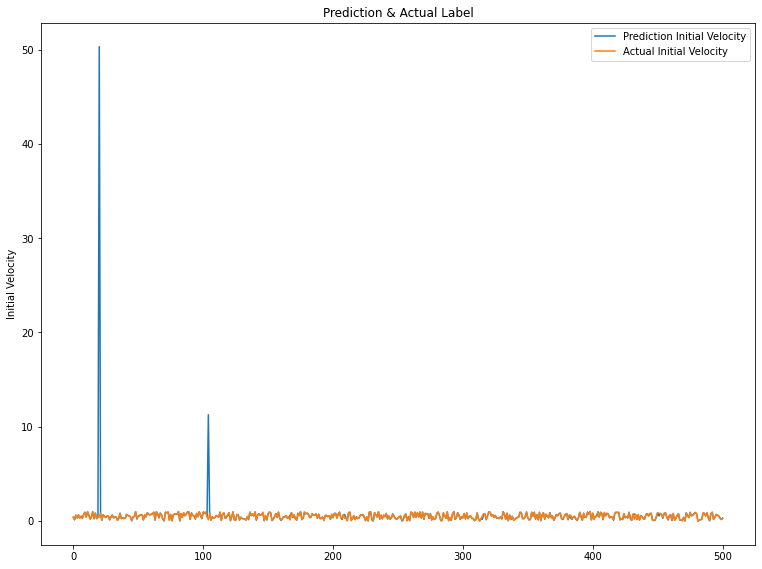

In [167]:
plt.figure(figsize=(12.8,9.6))
plt.title('Prediction & Actual Label')
plt.ylabel('Initial Velocity')
plt.plot(range(len(initialize_predict)),predict_list,label='Prediction Initial Velocity')
plt.plot(range(len(initialize_target)),target_list, label='Actual Initial Velocity')
plt.legend()

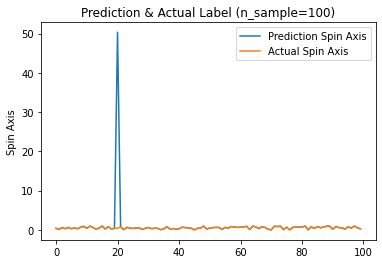

In [168]:
plt.title('Prediction & Actual Label (n_sample=100)')
plt.ylabel('Spin Axis')
plt.plot(range(100),predict_list[:100],label='Prediction Spin Axis')
plt.plot(range(100),target_list[:100], label='Actual Spin Axis')
plt.legend()

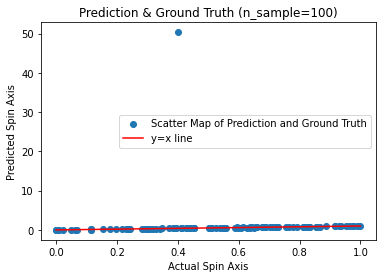

In [169]:
plt.title('Prediction & Ground Truth (n_sample=100)')
plt.xlabel('Actual Spin Axis')
plt.ylabel('Predicted Spin Axis')
plt.scatter(target_list[:100],predict_list[:100],label='Scatter Map of Prediction and Ground Truth')
plt.plot([0,1],[0,1],label='y=x line',color='r')
plt.legend()

In [723]:
show = pd.DataFrame(
{'True label(XZ theta)': list(initialize_target),'Predict label(XZ theta)': list(initialize_predict)})
show[0:10]

,True label(XZ theta),Predict label(XZ theta)
0,[-1.0082168953237625],[-1.0122430490861258]
1,[-4.475240749833411],[-4.5056637873261645]
2,[1.5364953977513],[1.5267596208158052]
3,[1.1315998643257652],[1.1449074309767837]
4,[-0.6701158542675906],[-0.6929525604697614]
5,[2.170067651526665],[2.142194233518242]
6,[4.865958415622928],[4.862993437131165]
7,[-2.6954958478985067],[-2.710920256745467]
8,[0.5011349127737419],[0.49274079009451166]
9,[4.872322489762608],[4.871821081469765]
